# Optimal Run Path For Kick Returners

This notebook documents our code for submission to the 2022 NFL Big Data Bowl.

Twitter contacts: `@taidn97`, `@RyanBrill_`, `@JRudoler`, `@ryanzgross`

Please view our Kaggle write up here: https://www.kaggle.com/jrudoler56/optimal-run-path-for-kick-returners

# Start the Code Session

Start the code session by importing the necessary packages and mounting the google drive in order to load our datasets.

In [6]:
### code to start my session
import numpy as np
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Create Raw Data Matrix of all Kickoff Returns

Install the Kaggle datasets to google drive. It only needs to be run once.

In [ ]:
# # ### GET DATASETS (only need to run once)
# from google.colab import files
# ### get kaggle.json from Kaggle website under account "create API token"
# ### content/drive/My\ Drive/kaggle/BDB22/
# files.upload()  #this will prompt you to upload the kaggle.json
# !pip install -q kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !ls ~/.kaggle
# !chmod 600 /root/.kaggle/kaggle.json  # set permission
# ! kaggle competitions download -c nfl-big-data-bowl-2022 -p /content/drive/My\ Drive/kaggle/BDB22
# ! unzip /content/drive/My\ Drive/kaggle/BDB22/plays.csv.zip
# ! unzip /content/drive/My\ Drive/kaggle/BDB22/tracking2018.csv.zip
# ! unzip /content/drive/My\ Drive/kaggle/BDB22/tracking2019.csv.zip
# ! unzip /content/drive/My\ Drive/kaggle/BDB22/tracking2020.csv.zip

In [ ]:
# # !mv kaggle.json drive/MyDrive/kaggle/BDB22/
# ! mv plays.csv drive/MyDrive/kaggle/BDB22/
# ! mv tracking2018.csv drive/MyDrive/kaggle/BDB22/
# ! mv tracking2019.csv drive/MyDrive/kaggle/BDB22/
# ! mv tracking2020.csv drive/MyDrive/kaggle/BDB22/

Create dataframe of ALL KICKOFF RETURNS. Since it takes such a long time to run, I run it once, save the result as a new dataframe, and load that dataframe later. Hence this code chunk only needs to be run once.

In [ ]:
### create dataframe of ALL KICKOFF RETURNS (only need to run once)

### function to get all kick returns from tracking data
def get_all_KR(track):
  KR_idxs = plays.query('specialTeamsPlayType == "Kickoff" & specialTeamsResult == "Return"')
  KR_idxs1 = KR_idxs[["gameId","playId"]]
  KR_idxs1["KR"] = True
  track1 = track.merge(KR_idxs1, on=['gameId', 'playId'], how='left')
  track1["KR"].fillna(value=False)
  all_KR_ = track1.query('KR == True')
  return all_KR_

### read raw tracking data
### need to stagger like this because the RAM is limited in colab...
plays = pd.read_csv('drive/My Drive/kaggle/BDB22/plays.csv')
## incorporate 2020 tracking data
track2020 = pd.read_csv('drive/My Drive/kaggle/BDB22/tracking2020.csv')
all_KR_2020 = get_all_KR(track2020)
del(track2020)
## incorporate 2019 tracking data
track2019 = pd.read_csv('drive/My Drive/kaggle/BDB22/tracking2019.csv')
all_KR_2019 = get_all_KR(track2019)
del(track2019)
all_KR = pd.concat([all_KR_2020, all_KR_2019])
del(all_KR_2020)
del(all_KR_2019)
## incorporate 2018 tracking data
track2018 = pd.read_csv('drive/My Drive/kaggle/BDB22/tracking2018.csv')
all_KR_2018 = get_all_KR(track2018)
del(track2018)
all_KR = pd.concat([all_KR, all_KR_2018])
del(all_KR_2018)
## view all Kick Returns dataset and write csv
all_KR.to_csv('drive/My Drive/kaggle/BDB22/all_KR.csv',index=False)

In [ ]:
### read all_KR dataset
all_KR = pd.read_csv('drive/My Drive/kaggle/BDB22/all_KR.csv')

### select relevant columns
all_KR = all_KR.sort_values(['gameId', 'playId','frameId'])
all_KR = all_KR.reset_index(drop=True)
all_KR = all_KR[['gameId','playId',"frameId","playDirection","x","y","s","a",
                 "o","dir","event","nflId","displayName","team"]]

### NOTE: playDirection == 'right' MEANS the kick returner moves 'left'
### make sure all kick returner movement is RIGHT (from small x to large x). 
### equivalently, make sure all playDirection == 'left', 
###    so we need to change all playDirection == 'right'.

all_KR['x'] = np.where(all_KR['playDirection']=='right',
                       120-all_KR['x'],
                       all_KR['x'])
all_KR['y'] = np.where(all_KR['playDirection']=='right',
                       53.3-all_KR['y'],
                       all_KR['y'])
all_KR['dir'] = np.where(all_KR['playDirection']=='right',
                         (180+all_KR['dir']) % 360,
                         all_KR['dir'])
all_KR['o'] = np.where(all_KR['playDirection']=='right',
                       (180+all_KR['o']) % 360,
                       all_KR['o'])

### check. make sure to look only after the row with. event == 'kick_received'.
# pd.set_option('max_rows', 200)
# all_KR[(all_KR["gameId"] == 2021010300) & (all_KR["playId"] == 395) & (all_KR["displayName"] == "Isaiah McKenzie")]
# all_KR[(all_KR["gameId"] == 2021010300) & (all_KR["playId"] == 395) & (all_KR["displayName"] == "football")]
# pd.reset_option('display.max_rows')

### get rid of "playDirection", since now all plays are going LEFT
all_KR = all_KR.drop(columns=["playDirection"])

### keep only the KICKOFF RETURN portion of the kickoff
###   from the time the offense catches the ball, until tackle/out of bounds/
print(set(all_KR["event"]))

ko_beg_events = ["kick_received"] #FIXME
ret_first = all_KR[all_KR['event'].isin(ko_beg_events)][["gameId","playId","frameId"]].drop_duplicates().rename(columns={"frameId":"frameId_0"})
ko_end_events = ["tackle", "out_of_bounds", "touchdown"] #FIXME: should this include touchdown?
ret_last = all_KR[all_KR['event'].isin(ko_end_events)][["gameId","playId","frameId"]].drop_duplicates().rename(columns={"frameId":"frameId_1"})
ret_boundaries = ret_first.merge(ret_last, on=['gameId', 'playId'], how='left')
all_KR = all_KR.merge(ret_boundaries, on=['gameId', 'playId'], how='left')
all_KR = all_KR.query('frameId_0 <= frameId & frameId <= frameId_1')
all_KR = all_KR.drop(columns=["frameId_0", "frameId_1"])

### "f_dist" distance from the football to the given player
football = all_KR.query('displayName == "football"')[["gameId","playId","frameId","x","y"]]
football = football.rename(columns={"x": "fx", "y": "fy"})
all_KR = all_KR.merge(football, on=['gameId', 'playId', 'frameId'], how='left')
all_KR["f_dist"] = np.sqrt((all_KR["x"] - all_KR["fx"])**2 + (all_KR["y"] - all_KR["fy"])**2)

### "returner", "returnTeam", "isFootball"
all_KR = all_KR.sort_values(by=['gameId', 'playId', 'frameId','team','f_dist'])
all_KR = all_KR.reset_index().drop(columns=["index"])
# all_KR[(all_KR["gameId"] == 2021010300) & (all_KR["playId"] == 395) & (all_KR["frameId"] == 56)]

returner = all_KR.loc[all_KR.query('displayName != "football"')\
                      .groupby(by=["gameId","playId","frameId"])\
                      .f_dist.idxmin()]
returner = returner.groupby(by=["gameId","playId"]).first().reset_index()[["gameId","playId","displayName","team"]].rename(columns={"displayName":"returner","team":"returnTeam"})


all_KR = all_KR.merge(returner, on=["gameId","playId"])
all_KR["returner"] = (all_KR["returner"] == all_KR["displayName"])
all_KR["returnTeam"] = (all_KR["returnTeam"] == all_KR["team"])
all_KR["isFootball"] = (all_KR["displayName"] == "football")
all_KR["f_dist"] = np.where(all_KR["returner"], 0, all_KR["f_dist"])
all_KR = all_KR.sort_values(by=['gameId', 'playId', 'frameId','team','f_dist'])
# k6[(k6["gameId"] == 2021010300) & (k6["playId"] == 395) & (k6["frameId"] == 56)]

### player index "p_idx" column:
###   d01 = closest defender,..., d11 = farthest defender
###   kr == returner, o02 = closest offender,..., o11 = farthest offender
### also, remove rows for football
all_KR = all_KR[~(all_KR["isFootball"])].drop(columns=["isFootball"])
all_KR['p_idx'] = (all_KR.groupby(by=["gameId","playId","frameId","returnTeam"]).cumcount()+1).apply(str)
all_KR['p_idx'] = np.where(all_KR['p_idx'].apply(len) >= 2, all_KR['p_idx'], '0'+all_KR['p_idx'])
all_KR['p_idx'] = np.where(all_KR['returnTeam'], 'o'+all_KR['p_idx'], 'd'+all_KR['p_idx'],)
all_KR['p_idx'] = np.where(all_KR['p_idx'] == 'o01', 'kr', all_KR['p_idx'])
# all_KR[(all_KR["gameId"] == 2021010300) & (all_KR["playId"] == 395) & (all_KR["frameId"] == 56)]

### player tag "p_tag" column:
###      player tag p_tag is different from player index p_idx because
###      we need d1 to be the SAME person for the ENTIRE kick !!
###   d01 = 1st defender,..., d11 = 11th defender 
###   kr == returner, o02 = 2nd offender,..., o11 = 11th offender
all_KR['notReturner'] = ~all_KR['returner']
all_KR = all_KR.sort_values(by=['gameId','playId','frameId','returnTeam','notReturner','displayName'])
all_KR['p_tag'] = (all_KR.groupby(by=['gameId','playId','frameId','returnTeam','notReturner']).cumcount()+1)
all_KR['p_tag'] = np.where(all_KR['returnTeam'], all_KR['p_tag']+1, all_KR['p_tag'])
all_KR['p_tag'] = all_KR['p_tag'].apply(str)
all_KR['p_tag'] = np.where(all_KR['p_tag'].apply(len) >= 2, all_KR['p_tag'], '0'+all_KR['p_tag'])
all_KR['p_tag'] = np.where(all_KR['returnTeam'], 'o'+all_KR['p_tag'], 'd'+all_KR['p_tag'])
all_KR['p_tag'] = np.where(all_KR['returner'], 'kr', all_KR['p_tag'])

# all_KR[(all_KR["gameId"] == 2021010300) & (all_KR["playId"] == 395) & (all_KR["frameId"] >= 56) &  (all_KR["frameId"] <= 57)]
###print(sorted(set(all_KR["p_idx"]))); print(sorted(set(all_KR["p_tag"])));

Create the *pre-feature-matrix* of all kickoff returns, which has the (x,y) position of every player during the given frame of the given kickoff.

In [ ]:
### select relevant columns: for each frame, get the (x,y,s,a,o,dir) value of each player
pre_feature_df_0 = all_KR[['gameId', 'playId','frameId','displayName','x','y','s','a','o','dir','p_idx','p_tag']]
# pre_feature_df[(pre_feature_df["gameId"] == 2021010300) & (pre_feature_df["playId"] == 395) & (pre_feature_df["frameId"] >= 56) &  (pre_feature_df["frameId"] <= 57)]

### pre_feature_df:  columns created in terms of P_IDX
pre_feature_df = pre_feature_df_0.set_index(['gameId', 'playId','frameId', 'p_idx']).unstack().sort_index(1, level=1)
pre_feature_df.columns = ['_'.join(col).strip() for col in pre_feature_df.columns.values]
pre_feature_df = pre_feature_df.reset_index()

### pre_feature_df_by_tag:  columns created in terms of P_IDX
### relevant for the animation of kick returns! want d_01 to be the same person, the 1st defender, for the entire return!
pre_feature_df_by_tag = pre_feature_df_0.set_index(['gameId', 'playId','frameId', 'p_tag']).unstack().sort_index(1, level=1)
pre_feature_df_by_tag.columns = ['_'.join(col).strip() for col in pre_feature_df_by_tag.columns.values]
pre_feature_df_by_tag = pre_feature_df_by_tag.reset_index()

# ### just the (x,y) position of each player [for now] ---> FALSE; we are actually using s, a, dir !!!!!
# filter_col = [col for col in pre_feature_df if col.startswith('x_') | col.startswith('y_')]
# pre_feature_df = pre_feature_df[filter_col]
# pre_feature_df.drop_duplicates(inplace=True)

### save the pre-feature-matrix
del(all_KR); del(pre_feature_df_0);
pre_feature_df.to_csv('drive/My Drive/kaggle/BDB22/pre_feature_df.csv', index=False)
pre_feature_df_by_tag.to_csv('drive/My Drive/kaggle/BDB22/pre_feature_df_by_tag.csv', index=False)
# list(pre_feature_df.columns)

# Response column $\Delta V$ of the regression

First, load the pre-feature data matrix consisting of the tracking data of every player of every frame of every kickoff return in 2018, 2019, and 2020.

In [ ]:
### load pre_feature_df
pre_feature_df = pd.read_csv('drive/My Drive/kaggle/BDB22/pre_feature_df.csv')
pre_feature_df

Now, let's compute $V$, the "value" of the ending yard line of the kickoff return. We define the value of a yardline $x$, where $x$ means $x$ yards away from scoring a touchdown, as the expected number of points of the next score given that you start with a first down at yard line $x$. To find $V_x$ for each $x$, we simply take the average value of all points of the next score from every first down at yard line $x$ from 2010 - 2018. Then, we smooth these values. We performed this computation using `nflFastR` data in a separate project. Below is a plot of $V_x$ as a function of $x$.

https://drive.google.com/file/d/1dswj7_vpIv_BiZasEHLg-NBTbzBnPE5q/view?usp=sharing

Please get the dataset `value_1st_down.csv` at 

https://drive.google.com/file/d/1cL66x1Ple4o5CTmd2a9o59Yl76bkNnv7/view?usp=sharing

In [ ]:
import cv2
from matplotlib import pyplot as plt
img = cv2.imread('/content/drive/MyDrive/kaggle/BDB22/value_1st_down.png')
img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (10,10))
plt.imshow(img_cvt)
plt.axis('off')
plt.show()

Now, we create the response column $V$.

In [ ]:
### read value_1st_down dataset
V_df = pd.read_csv('drive/My Drive/kaggle/BDB22/value_1st_down.csv')
### transform yardline column to match the [0,120] x-axis of our tracking data
###   recalling that our kick returners are moving Right
V_df["x"] = 120 - (V_df["ydline"] + 10)
V_df = V_df.drop(columns=["ydline"])
V_df = V_df.rename(columns={"V1s": "V"})
V_df

To create the response column for our regression, we want to know how much value the remainder of the kick return *added*. For instance, if a frame is really just before a player is tackled and they have no decisions left to make, we don't want that frame to have much value.

To achieve this, we need the change in $V$ from the current frame to the end of the return. We simply take the last frame (row) of each kickoff return (group), take the $x$ yardline of that frame, and compute the value of that yardline. Then we do the same for the current frame of the return, and take the difference of the two values.

So, our response column is:

$\Delta V = V_f - V_i$

In [ ]:
### function V(x) computes the value of yardline x.
### linearly interpolate if x is not an integer.
def V(x):
  x0 = np.floor(x)
  x1 = np.ceil(x)
  if x0 < 11:
    x0 = 11 
    x1 = 11
  elif x1 > 109:
    x0 = 109
    x1 = 109
    
  V0 = float(V_df.query(f'x=={x0}')["V"])
  V1 = float(V_df.query(f'x=={x1}')["V"])
  Vx = V0 + (x1-x)*(V1-V0)
  return Vx

### check
V(108.4)

6.093207494974796

In [ ]:
# ### dV: V_final - V_curr, for each kr frame. 

# ### value of current yard line for every frame
# pre_feature_df["curr_V"] = pre_feature_df["x_kr"].apply(V)

# ### final yard line of each play
# x_endOfPlay = pre_feature_df.groupby(by=["gameId","playId"]).last()["curr_V"].reset_index()
# x_endOfPlay["final_V"] = x_endOfPlay["curr_V"]
# x_endOfPlay = x_endOfPlay.drop(columns=["curr_V"])
# x_endOfPlay

# ### save the response column
# V_mat = pre_feature_df.merge(x_endOfPlay,how='left')[["gameId","playId","frameId","curr_V","final_V"]]
# V_mat["dV"] = V_mat["final_V"] - V_mat["curr_V"]
# V_mat.to_csv('drive/My Drive/kaggle/BDB22/V.csv')
# V_mat

In [ ]:
# starting and ending yard line of each play
x_startOfPlay = pre_feature_df.groupby(by=["gameId","playId"]).first()["x_kr"].reset_index()
x_endOfPlay = pre_feature_df.groupby(by=["gameId","playId"]).last()["x_kr"].reset_index()
# value of starting and ending yard line of each play
x_startOfPlay["V_s"] = x_startOfPlay["x_kr"].apply(V)
x_endOfPlay["V_f"] = x_endOfPlay["x_kr"].apply(V)
Vf_minus_Vs = x_endOfPlay.merge(x_startOfPlay.drop(columns=['x_kr']), how='left')
# EPA for each play is difference between value at start and end. 
Vf_minus_Vs["Vf_minus_Vs"] = Vf_minus_Vs["V_f"] - Vf_minus_Vs["V_s"]
# get Vf-Vs for every frame
g = pre_feature_df[['gameId', 'playId', 'frameId']]
g = g.merge(Vf_minus_Vs[['gameId', 'playId','Vf_minus_Vs','V_f']], how='left')
### save the response column
g.to_csv('drive/My Drive/kaggle/BDB22/Vf_minus_Vs.csv', index=False)
g

# Create Feature Matrix for Regression 

## Load the pre-feature data matrix

First, load the pre-feature data matrix consisting of the tracking data of every player of every frame of every kickoff return in 2018, 2019, and 2020.

In [ ]:
### load pre_feature_df
pre_feature_df = pd.read_csv('drive/My Drive/kaggle/BDB22/pre_feature_df.csv')
pre_feature_df.head()
#list(pre_feature_df.columns)

,gameId,playId,frameId,a_d01,dir_d01,displayName_d01,o_d01,p_tag_d01,s_d01,x_d01,y_d01,a_d02,dir_d02,displayName_d02,o_d02,p_tag_d02,s_d02,x_d02,y_d02,a_d03,dir_d03,displayName_d03,o_d03,p_tag_d03,s_d03,x_d03,y_d03,a_d04,dir_d04,displayName_d04,o_d04,p_tag_d04,s_d04,x_d04,y_d04,a_d05,dir_d05,displayName_d05,o_d05,p_tag_d05,...,a_o07,dir_o07,displayName_o07,o_o07,p_tag_o07,s_o07,x_o07,y_o07,a_o08,dir_o08,displayName_o08,o_o08,p_tag_o08,s_o08,x_o08,y_o08,a_o09,dir_o09,displayName_o09,o_o09,p_tag_o09,s_o09,x_o09,y_o09,a_o10,dir_o10,displayName_o10,o_o10,p_tag_o10,s_o10,x_o10,y_o10,a_o11,dir_o11,displayName_o11,o_o11,p_tag_o11,s_o11,x_o11,y_o11
0,2018090600,677,53,1.89,280.27,Damontae Kazee,281.50,d01,9.31,40.75,33.99,1.72,288.58,Russell Gage,292.28,d11,9.01,41.11,32.25,2.14,287.29,Foye Oluokun,279.98,d04,8.97,43.08,38.77,2.05,278.30,Eric Saubert,286.72,d03,8.92,44.18,42.04,0.44,270.07,Justin Hardy,251.62,d06,...,3.09,308.57,Kamu Grugier-Hill,83.47,o06,5.36,34.23,31.98,1.39,341.49,LaRoy Reynolds,99.09,o07,2.59,39.07,41.27,2.56,217.02,Rasul Douglas,97.59,o09,1.13,39.83,44.49,2.27,298.77,Nate Gerry,89.45,o08,4.83,37.43,29.16,2.01,301.01,Avonte Maddox,122.56,o02,4.94,39.08,24.57
1,2018090600,677,54,2.09,281.36,Damontae Kazee,279.69,d01,9.22,39.84,34.17,1.80,288.69,Russell Gage,290.09,d11,8.89,40.26,32.54,2.32,289.04,Foye Oluokun,283.10,d04,8.92,42.23,39.06,2.52,278.77,Eric Saubert,289.58,d03,8.64,43.32,42.17,0.54,270.15,Justin Hardy,251.62,d06,...,3.46,312.88,Kamu Grugier-Hill,83.47,o06,5.07,33.84,32.32,1.24,344.99,LaRoy Reynolds,100.35,o07,2.64,38.99,41.53,2.18,208.20,Rasul Douglas,98.28,o09,1.30,39.76,44.38,2.23,298.88,Nate Gerry,89.45,o08,4.61,37.02,29.39,2.10,298.30,Avonte Maddox,126.29,o02,4.85,38.66,24.81
2,2018090600,677,55,2.44,282.40,Damontae Kazee,279.69,d01,9.03,38.95,34.36,1.94,288.43,Russell Gage,289.23,d11,8.75,39.42,32.82,2.32,290.46,Foye Oluokun,283.10,d04,8.85,41.39,39.36,2.89,278.94,Eric Saubert,286.88,d03,8.34,42.48,42.29,0.84,270.45,Justin Hardy,249.81,d06,...,3.62,317.26,Kamu Grugier-Hill,83.47,o06,4.81,33.50,32.67,1.03,347.26,LaRoy Reynolds,99.60,o07,2.59,38.93,41.78,2.17,300.21,Nate Gerry,89.45,o08,4.41,36.63,29.61,1.47,207.97,Rasul Douglas,100.91,o09,1.42,39.69,44.26,2.16,294.51,Avonte Maddox,129.19,o02,4.93,38.20,25.02
3,2018090600,677,56,2.79,284.21,Damontae Kazee,280.79,d01,8.87,38.08,34.57,2.28,286.59,Russell Gage,288.43,d11,8.61,38.59,33.07,2.33,291.87,Foye Oluokun,283.78,d04,8.78,40.57,39.68,4.89,279.24,Eric Saubert,296.00,d03,7.46,41.73,42.41,0.93,270.07,Justin Hardy,255.90,d06,...,3.51,321.49,Kamu Grugier-Hill,85.51,o06,4.66,33.19,33.04,0.72,347.76,LaRoy Reynolds,100.55,o07,2.59,38.87,42.03,2.12,301.95,Nate Gerry,88.16,o08,4.23,36.26,29.84,0.50,211.82,Rasul Douglas,99.71,o09,1.40,39.61,44.15,2.22,291.34,Avonte Maddox,139.85,o02,4.99,37.74,25.21
4,2018090600,677,57,3.36,286.70,Damontae Kazee,282.14,d01,8.66,37.23,34.80,2.71,284.82,Russell Gage,285.72,d11,8.43,37.76,33.29,2.31,293.23,Foye Oluokun,283.78,d04,8.71,39.75,40.01,5.47,279.64,Eric Saubert,307.38,d03,6.87,41.03,42.53,1.15,269.13,Justin Hardy,256.98,d06,...,3.36,325.33,Kamu Grugier-Hill,87.17,o06,4.48,32.92,33.41,2.14,305.47,Nate Gerry,86.41,o08,4.11,35.91,30.07,0.67,348.22,LaRoy Reynolds,99.74,o07,2.54,38.82,42.28,0.53,218.24,Rasul Douglas,100.82,o09,1.36,39.53,44.04,2.15,288.39,Avonte Maddox,145.00,o02,5.09,37.26,25.38


## Feature: $x_{kr}$

Feature 
$$ x_{kr} $$

We need this feature because the value of a kick return depends on the yard line of the kick returner.

In [ ]:
def create_F1(pre_feature_df):
  return pd.concat([pre_feature_df["x_kr"]], axis=1, keys=["x_kr"])

In [ ]:
F1 = create_F1(pre_feature_df)
F1

,x_kr
0,11.53
1,11.62
2,11.78
3,11.95
4,12.16
...,...
143067,28.29
143068,28.69
143069,29.04
143070,29.37


## Feature: Distance to the sideline

Feature 
$$\text{dist_to_sideline} = \min \{|y_{kr} - 0|, |53.3 - y_{kr}| \}.$$

We need this feature because the value of a kick return frame depends on how close the kick returner is to the sideline. We need to encode that if the kick returner steps out of bounds, the play is over.

In [ ]:
def create_F1a(pre_feature_df):
  dist_to_sideline = np.minimum(
    np.abs(pre_feature_df["y_kr"] - 0), 
    np.abs(53.3 - pre_feature_df["y_kr"])
  )
  #inv_dist_sq = pd.concat([1/dist_to_sideline**2], axis=1, keys=["sideline_feature"])
  return pd.concat([dist_to_sideline], axis=1, keys=["sideline_feature"]) #inv_dist_sq

In [ ]:
F1a = create_F1a(pre_feature_df)
F1a

,sideline_feature
0,10.85
1,10.98
2,11.14
3,11.32
4,11.51
...,...
143067,6.38
143068,5.87
143069,5.36
143070,4.86


## Feature: Joey's Projection feature

$y$-distance to $j^{th}$ closest defender when the KR is projected onto the avg. $x$ location of the defenders

$\Delta y_{dj} = (y_{dj} - y_{kr}) + (\frac{1}{11}\sum_{j=1}^{11}x_{j} - x_{kr})*\tan(\theta)$

Where $\theta = -(dir_{kr}-90)$


<!-- -------

Let the avg. $x$ location of the defenders be given by
$$\overline{x} = \frac{1}{11}\sum_{j=1}^{11} x_j.$$
We want to find
$$d(y_{kr \text{ proj onto } \overline{x}}, \ y_{dj}).$$
We know
$$d(y_{kr \text{ proj onto } \overline{x}}, \ y_{kr}) = (\overline{x} - x_{kr}) \cdot \tan\theta.$$
We know
$$d(y_{dj}, y_{kr}) = y_{dj} - y_{kr}.$$
Therefore
$$\Delta y_{dj} = (y_{dj} - y_{kr}) + (\overline{x} - x_{kr}) \cdot \tan\theta.$$
Draw it out... -->


In [ ]:
### NOTE: need to put each feature creation inside it's own function
### for the kick return simulation later on.
def create_F3(pre_feature_df):
  all_cols = pre_feature_df.columns.values
  def_x_cols = np.array([col for col in all_cols if col.count('x_d')])
  def_y_cols = np.array([col for col in all_cols if col.count('y_d')])
  x_dist = (pre_feature_df[def_x_cols].mean(1) - pre_feature_df['x_kr'])
  y_proj = pre_feature_df['y_kr'] + x_dist * np.tan(-(np.radians(pre_feature_df['dir_kr'] - 90)))
  # clip projected values to limits of field - necessary?
  y_proj = np.clip(y_proj, 0, 53.3)
  F3 = pd.DataFrame()
  F3[[f"proj_y_d0{j}" if j < 10 else f"proj_y_d{j}" for j in range(1, 12)]] = pre_feature_df[def_y_cols].sub(y_proj, axis='index')
  return F3
  # all_cols = pre_feature_df.columns.values
  # def_x_cols = np.array([col for col in all_cols if col.count('x_d')])
  # def_y_cols = np.array([col for col in all_cols if col.count('y_d')])
  # x_dist = (pre_feature_df[def_x_cols].mean(1) - pre_feature_df['x_kr'])
  # y_dist_1 = x_dist * np.tan(np.radians(pre_feature_df['dir_kr'] - 90))
  # y_dist_2 = pre_feature_df[def_y_cols].sub(pre_feature_df['y_kr'], axis='index')
  # y_proj_dist = y_dist_2.add(y_dist_1, axis='index')
  # F3 = y_proj_dist #1/y_proj_dist**2
  # # clip projected values to limits of field - necessary?
  # F3 = np.clip(F3, 0, 53.3)
  # F3.columns = [f"proj_y_d0{j}" if j < 10 else f"proj_y_d{j}" for j in range(1, 12)]
  # return F3

In [ ]:
F3 = create_F3(pre_feature_df)
F3

,proj_y_d01,proj_y_d02,proj_y_d03,proj_y_d04,proj_y_d05,proj_y_d06,proj_y_d07,proj_y_d08,proj_y_d09,proj_y_d10,proj_y_d11
0,33.990000,32.250000,38.770000,42.040000,49.790000,27.630000,24.920000,21.750000,46.240000,37.210000,17.860000
1,34.170000,32.540000,39.060000,42.170000,49.800000,28.000000,25.290000,22.050000,46.320000,37.370000,18.360000
2,27.008275,25.468275,32.008275,34.938275,42.448275,21.018275,18.308275,14.978275,39.038275,30.168275,11.508275
3,23.352521,21.852521,28.462521,31.192521,38.592521,17.542521,14.812521,11.382521,35.242521,26.442521,8.142521
4,19.378053,17.868053,24.588053,27.108053,34.378053,13.748053,10.968053,7.448053,31.088053,22.368053,4.438053
...,...,...,...,...,...,...,...,...,...,...,...
143067,7.050000,7.060000,5.310000,9.700000,7.860000,7.010000,11.640000,15.080000,12.550000,26.960000,14.640000
143068,6.730000,6.560000,4.960000,9.140000,7.780000,6.700000,11.050000,14.400000,11.970000,14.210000,26.620000
143069,6.370000,4.600000,6.090000,8.600000,6.370000,7.670000,10.480000,13.720000,11.400000,13.780000,26.230000
143070,6.010000,4.240000,5.660000,8.070000,6.030000,7.530000,9.930000,13.030000,10.830000,13.350000,25.820000


## Indicator Variable to be used as an Interaction term in a Feature: Is the $j^{th}$ defender blocked?

*Description*

* x: Player position along the long axis of the field, 0 - 120 yards. See Figure 1 below. (numeric)
* y: Player position along the short axis of the field, 0 - 53.3 yards. See Figure 1 below. (numeric)
* s: Speed in yards/second (numeric)
* a: Acceleration in yards/second^2 (numeric)
* dis: Distance traveled from prior time point, in yards (numeric)
* o: Player orientation (deg), 0 - 360 degrees (numeric)
* dir: Angle of player motion (deg), 0 - 360 degrees (numeric)

In [ ]:
import numpy as np
import pandas as pd
import warnings
from google.colab import drive
drive.mount('/content/drive')
warnings.simplefilter('ignore')
pd.set_option('display.width', 3000)
pd.set_option('display.max_columns', 500)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def line_coefs(x1, y1, dir, length=150):
  """
  length is arbitrarily long, so 150
  return coefs (A, B, C) of line equation by two points provided
  """
  x2 = x1 + length*np.cos(dir)
  y2 = y1 + length*np.sin(dir)
  A = (y1 - y2)
  B = (x2 - x1)
  C = (x1*y2 - x2*y1)
  return A, B, -C


def intersection(L1, L2):
  """
  line L is tuple size 3
  return intersection point (x, y) between blocker line, defender line
  """
  D  = L1[0] * L2[1] - L1[1] * L2[0]
  Dx = L1[2] * L2[1] - L1[1] * L2[2]
  Dy = L1[0] * L2[2] - L1[2] * L2[0]
  if D != 0:
    x = Dx / D
    y = Dy / D
    return x,y
  else:
    return False


def to_intersec_first(b_xy, d_xy, i_xy, b_speed, d_speed):
  """
  we assume player takes fastest path to their intersection
  return True if d player takes less or equal time to intersection compared to b
  """
  blk_dis_to_intersec = np.sqrt((b_xy[0] - i_xy[0])**2 + (b_xy[1] - i_xy[1])**2)
  def_dis_to_intersec = np.sqrt((d_xy[0] - i_xy[0])**2 + (d_xy[1] - i_xy[1])**2)
  
  return (blk_dis_to_intersec/b_speed >= def_dis_to_intersec/d_speed)
  
# # test
# def_line = line_coefs(73.89, 18.69, 135.45, 100)
# blocker_line = line_coefs(99.19, 16.89, 244.88, 100)
# intersec_xy = intersection(def_line, blocker_line)
# to_intersec_first(b_xy=(89.21, 13.91), d_xy=(73.89, 18.69), i_xy=intersec_xy, b_speed=2.14, d_speed=5.90)

In [ ]:
from collections import defaultdict
from queue import PriorityQueue
from tqdm import tqdm

def create_F4(pre_feature_df):
    # init F4 df
    F4 = pd.DataFrame()
    # CLEANUP: Don't need first two columns
    # for i in range(1, 12): # blocked_dj
    #     i = "%02d" % i
    #     F4["blocked_d"+i] = []
    # for i in range(1, 12):
    #     i = "%02d" % i
    #     F4["cant_catch_kr_d"+i] = [] # cant_catch_kr_dj
    for i in range(1, 12):
        i = "%02d" % i
        F4["master_block_d"+i] = [] # master_block_dj

    # loop through frames
    for idx, row in tqdm(pre_feature_df.iterrows(), desc="Blocking features iteration"):
        defenders = ["d%02d" % d for d in range(1, 12)]
        blockers = ["o%02d" % d for d in range(2, 12)] # minus kr

        # available player arrays to be modified
        defenders_blocked = defenders.copy()
        defenders_behind_kr = defenders.copy()  # defenders who cannot catch kr
        possible_blockers = defaultdict(list)

        for d in defenders:
            d_line = line_coefs(row["x_"+d], row["y_"+d], row["dir_"+d])
            kr_line = line_coefs(row["x_kr"], row["y_kr"], row["dir_kr"])

            intersec_kr_xy = intersection(kr_line, d_line)

            # if intersection exists between kr and defender
            if intersec_kr_xy:
              if not to_intersec_first(kr_line, d_line, intersec_kr_xy, row["s_kr"], row["s_"+d]):
                defenders_behind_kr.remove(d)

            for b in blockers:
              b_line = line_coefs(row["x_"+b], row["y_"+b], row["dir_"+b])
              intersec_blocked_xy = intersection(d_line, b_line)

              # if intersection exists between blocker and defender
              if intersec_blocked_xy:
                if to_intersec_first(d_line, b_line, intersec_blocked_xy, row["s_"+b], row["s_"+d]):
                  possible_blockers[d].append(b)                    

        # continue for feature dj_is_blocked
        # priority queue to check defenders with fewest possible blockers first (not perfect)
        queue = PriorityQueue()
        for d in defenders_blocked:
            queue.put((len(possible_blockers[d]), d))
        while not queue.empty():
            d = queue.get()[1]
            for b in possible_blockers[d]:
                if b in blockers: # if possible blocker is still available, then remove the match up
                    defenders_blocked.remove(d)
                    blockers.remove(b)
                    break

        # write
        bj = np.array([1 if ("d%02d" % i) in defenders_blocked else 0 for i in range(1, 12)])
        cj = np.array([1 if ("d%02d" % i) in defenders_behind_kr else 0 for i in range(1, 12)])
        aj = cj*(1-bj)  # product of the 2 indicator vars
        # new_row = np.concatenate((bj, cj, aj), axis=None)
        new_row = aj
        F4.loc[idx] = new_row

    return F4

In [ ]:
sample = pre_feature_df.copy()[:200]
F4 = create_F4(sample)
F4.head()

Blocking features iteration: 200it [00:01, 135.11it/s]


,master_block_d01,master_block_d02,master_block_d03,master_block_d04,master_block_d05,master_block_d06,master_block_d07,master_block_d08,master_block_d09,master_block_d10,master_block_d11
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


## Feature: Segmented Distance to $j^{th}$ closest defender

Denote the distance between the kick returner $kr$ and the $j^{th}$ closest defender $dj$ as
$$d(kr,dj) := \sqrt{(x_{kr}-x_{dj})^2 + (y_{kr}-y_{dj})^2}.$$

Let $\lambda_1$ and $\lambda_2$ be hyperparameters encoding how close $kr$ and $dj$ are in terms of $x$-distance. Then, in our regression, we want terms indicating the distance of $kr$ to $dj$, with different coefficients depending how $x$-close they are, and whether the defender is in front of or behind the kicker.

Also, as discussed in the previous section, let $M_j$ be the _master-blocked_ indicator, which is 1 if $dj$ is able to catch $kr$ but is blocked by some blocker, and 0 else. In our regression, we want different coefficients for the distance from $kr$ to $dj$ depending on whether $dj$ is blocked or not. In other words, whether $dj$ is blocked or not is an interaction term with his distance to $kr$, which makes sense because a blocked defender should be worth more to the returning team than a free defender.

So, for the $j^{th}$ defender, we have 8 segmented-distance features:

\begin{align*}
  & d(kr,dj)  \cdot \unicode{x1D7D9}\{ x_{kr} - x_{dj} \in (\lambda_1,\infty) \} \cdot M_j \\
  & d(kr,dj) \cdot \unicode{x1D7D9}\{ x_{kr} - x_{dj} \in (\lambda_1,\infty) \} \cdot (1-M_j)  \\
  & d(kr,dj)  \cdot\unicode{x1D7D9}\{ x_{kr} - x_{dj} \in (0,\lambda_1] \} \cdot M_j \\
  & d(kr,dj)  \cdot\unicode{x1D7D9}\{ x_{kr} - x_{dj} \in (0,\lambda_1] \} \cdot (1-M_j) \\
  & d(kr,dj) \cdot \unicode{x1D7D9}\{ x_{kr} - x_{dj} \in (-\lambda_2,0] \} \cdot M_j  \\
  & d(kr,dj)  \cdot \unicode{x1D7D9}\{ x_{kr} - x_{dj} \in (-\lambda_2,0] \} \cdot (1-M_j) \\
  & d(kr,dj) \cdot \unicode{x1D7D9}\{ x_{kr} - x_{dj} \in (-\infty, -\lambda_2] \} \cdot M_j  \\
  & d(kr,dj) \cdot \unicode{x1D7D9}\{ x_{kr} - x_{dj} \in (-\infty, -\lambda_2] \} \cdot (1-M_j)  \\
\end{align*}

For now, we set $\lambda_1 = 2$ and $\lambda_2 = 2$. If inclined, we can do a cross validation to determine better values for these hyperparameters.

In [ ]:
### load Tai's pre-run big feature matrix and isolate the desired variables
Tai = pd.read_csv('drive/My Drive/kaggle/BDB22/Tai_big_matrix.csv')
### relevant columns: all 11 MASTER_BLOCK_DJ columns
Tai = Tai[[col for col in Tai.columns if col.startswith("master_block_")]]

In [ ]:
def create_F2(pre_feature_df):
  lambda_1 = 2; lambda_2 = 2;
  F2_data = []
  for j in range(1,12):
    #print(j)
    x_dj = pre_feature_df[f"x_d0{j}" if j < 10 else f"x_d{j}"]
    y_dj = pre_feature_df[f"y_d0{j}" if j < 10 else f"y_d{j}"]
    x_kr = pre_feature_df["x_kr"]
    y_kr = pre_feature_df["y_kr"]
    M_j = Tai[f"master_block_d0{j}" if j < 10 else f"master_block_d{j}"]
    # distance
    ##dist = np.sqrt((x_kr - x_dj)**2 + (y_kr - y_dj)**2)
    d = np.sqrt((x_kr - x_dj)**2 + (y_kr - y_dj)**2) #1/( (x_kr - x_dj)**2 + (y_kr - y_dj)**2 )
    x_diff = x_kr - x_dj
    # how x-close is dj to kr
    seg1 = x_diff > lambda_1
    seg2 = np.logical_and(0 < x_diff, x_diff <= lambda_1)
    seg3 = np.logical_and(-lambda_2 < x_diff, x_diff <= 0)
    seg4 = x_diff <= -lambda_2
    # feature: segmented distance
    F2_data.append(seg1*d*M_j)
    F2_data.append(seg1*d*(1-M_j))
    F2_data.append(seg2*d*M_j)
    F2_data.append(seg2*d*(1-M_j))
    F2_data.append(seg3*d*M_j)
    F2_data.append(seg3*d*(1-M_j))
    F2_data.append(seg4*d*M_j)
    F2_data.append(seg4*d*(1-M_j))
    # F2_data.append(seg1*d)
    # F2_data.append(seg2*d)
    # F2_data.append(seg3*d)
    # F2_data.append(seg4*d)

  F2 = pd.concat(F2_data, axis=1)
  del(F2_data)
  # F2.columns = [f"segD{k}_d0{j}" if j < 10 else f"segD{k}_d{j}" for j in range(1,12) for k in range(1,5)] 
  F2.columns = [f"segD{k}_d0{j}" if j < 10 else f"segD{k}_d{j}" for j in range(1,12) for k in range(1,9)] 
  return(F2)

In [ ]:
F2 = create_F2(pre_feature_df)
F2

,segD1_d01,segD2_d01,segD3_d01,segD4_d01,segD5_d01,segD6_d01,segD7_d01,segD8_d01,segD1_d02,segD2_d02,segD3_d02,segD4_d02,segD5_d02,segD6_d02,segD7_d02,segD8_d02,segD1_d03,segD2_d03,segD3_d03,segD4_d03,segD5_d03,segD6_d03,segD7_d03,segD8_d03,segD1_d04,segD2_d04,segD3_d04,segD4_d04,segD5_d04,segD6_d04,segD7_d04,segD8_d04,segD1_d05,segD2_d05,segD3_d05,segD4_d05,segD5_d05,segD6_d05,segD7_d05,segD8_d05,...,segD1_d07,segD2_d07,segD3_d07,segD4_d07,segD5_d07,segD6_d07,segD7_d07,segD8_d07,segD1_d08,segD2_d08,segD3_d08,segD4_d08,segD5_d08,segD6_d08,segD7_d08,segD8_d08,segD1_d09,segD2_d09,segD3_d09,segD4_d09,segD5_d09,segD6_d09,segD7_d09,segD8_d09,segD1_d10,segD2_d10,segD3_d10,segD4_d10,segD5_d10,segD6_d10,segD7_d10,segD8_d10,segD1_d11,segD2_d11,segD3_d11,segD4_d11,segD5_d11,segD6_d11,segD7_d11,segD8_d11
0,0.0,0.0,0.0,0.000000,0.0,0.000000,30.420059,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,31.289238,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,31.763893,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,32.652574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.333762,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,36.996720,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,38.422739,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,39.153863,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,41.869192,0.0,0.0,0.0,0.0,0.0,0.0,46.028863,0.000000
1,0.0,0.0,0.0,0.000000,0.0,0.000000,29.373303,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,30.263807,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,30.783107,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,31.700355,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.378905,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,35.852802,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,37.382630,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,38.398908,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,41.089252,0.0,0.0,0.0,0.0,0.0,0.0,45.050018,0.000000
2,0.0,0.0,0.0,0.000000,0.0,0.000000,28.267453,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,29.175421,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,29.742093,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,30.700275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.364674,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,34.633113,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,36.270729,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,37.578830,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,40.248354,0.0,0.0,0.0,0.0,0.0,0.0,43.996277,0.000000
3,0.0,0.0,0.0,0.000000,0.0,0.000000,27.160357,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,28.090527,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,28.712269,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,29.783104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.363128,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,33.395181,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,35.146078,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,36.754058,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,39.407503,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,42.949325
4,0.0,0.0,0.0,0.000000,0.0,0.000000,26.026237,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,26.974247,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,27.647360,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,28.879482,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.317284,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,32.122206,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,33.983809,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,35.901623,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,38.528203,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,41.863594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143067,0.0,0.0,0.0,1.525057,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,2.254972,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,2.746962,0.0,0.0,0.000000,3.520128,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,6.073096,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,7.452919,0.0,0.0,0.0,0.0,0.0,0.0,11.744875,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,11.844028,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,20.761599,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,20.965698
143068,0.0,0.0,0.0,0.000000,0.0,1.958877,0.000000,0.0,0.0,0.0,0.0,2.087343,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.

## Create and store full feature matrix



In [ ]:
### create and store full feature matrix
def create_feature_matrix(pre_feature_df):
  return pd.concat(
    [create_F1(pre_feature_df), # x_kr
     ############create_F1a(pre_feature_df), # distance to sideline
     create_F3(pre_feature_df), # joey projection feature
     create_F2(pre_feature_df)], # segmented distance (interacted with is_blocked)
     axis=1
  )

In [ ]:
feature_matrix = create_feature_matrix(pre_feature_df)
feature_matrix.to_csv('drive/My Drive/kaggle/BDB22/feature_matrix.csv', index=False)
feature_matrix

,x_kr,proj_y_d01,proj_y_d02,proj_y_d03,proj_y_d04,proj_y_d05,proj_y_d06,proj_y_d07,proj_y_d08,proj_y_d09,proj_y_d10,proj_y_d11,segD1_d01,segD2_d01,segD3_d01,segD4_d01,segD5_d01,segD6_d01,segD7_d01,segD8_d01,segD1_d02,segD2_d02,segD3_d02,segD4_d02,segD5_d02,segD6_d02,segD7_d02,segD8_d02,segD1_d03,segD2_d03,segD3_d03,segD4_d03,segD5_d03,segD6_d03,segD7_d03,segD8_d03,segD1_d04,segD2_d04,segD3_d04,segD4_d04,...,segD1_d07,segD2_d07,segD3_d07,segD4_d07,segD5_d07,segD6_d07,segD7_d07,segD8_d07,segD1_d08,segD2_d08,segD3_d08,segD4_d08,segD5_d08,segD6_d08,segD7_d08,segD8_d08,segD1_d09,segD2_d09,segD3_d09,segD4_d09,segD5_d09,segD6_d09,segD7_d09,segD8_d09,segD1_d10,segD2_d10,segD3_d10,segD4_d10,segD5_d10,segD6_d10,segD7_d10,segD8_d10,segD1_d11,segD2_d11,segD3_d11,segD4_d11,segD5_d11,segD6_d11,segD7_d11,segD8_d11
0,11.53,33.990000,32.250000,38.770000,42.040000,49.790000,27.630000,24.920000,21.750000,46.240000,37.210000,17.860000,0.0,0.0,0.0,0.000000,0.0,0.000000,30.420059,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,31.289238,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,31.763893,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,36.996720,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,38.422739,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,39.153863,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,41.869192,0.0,0.0,0.0,0.0,0.0,0.0,46.028863,0.000000
1,11.62,34.170000,32.540000,39.060000,42.170000,49.800000,28.000000,25.290000,22.050000,46.320000,37.370000,18.360000,0.0,0.0,0.0,0.000000,0.0,0.000000,29.373303,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,30.263807,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,30.783107,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,35.852802,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,37.382630,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,38.398908,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,41.089252,0.0,0.0,0.0,0.0,0.0,0.0,45.050018,0.000000
2,11.78,27.008275,25.468275,32.008275,34.938275,42.448275,21.018275,18.308275,14.978275,39.038275,30.168275,11.508275,0.0,0.0,0.0,0.000000,0.0,0.000000,28.267453,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,29.175421,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,29.742093,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,34.633113,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,36.270729,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,37.578830,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,40.248354,0.0,0.0,0.0,0.0,0.0,0.0,43.996277,0.000000
3,11.95,23.352521,21.852521,28.462521,31.192521,38.592521,17.542521,14.812521,11.382521,35.242521,26.442521,8.142521,0.0,0.0,0.0,0.000000,0.0,0.000000,27.160357,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,28.090527,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,28.712269,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,33.395181,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,35.146078,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,36.754058,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,39.407503,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,42.949325
4,12.16,19.378053,17.868053,24.588053,27.108053,34.378053,13.748053,10.968053,7.448053,31.088053,22.368053,4.438053,0.0,0.0,0.0,0.000000,0.0,0.000000,26.026237,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,26.974247,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,27.647360,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,32.122206,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,33.983809,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,35.901623,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,38.528203,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,41.863594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143067,28.29,7.050000,7.060000,5.310000,9.700000,7.860000,7.010000,11.640000,15.080000,12.550000,26.960000,14.640000,0.0,0.0,0.0,1.525057,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,2.254972,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,2.746962,0.0,0.0,0.000000,3.520128,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,7.452919

# Perform the Regression to find $\hat{f}$

## Load data & create training/testing datasets

In [ ]:
### OLD CODE

# ### training set is random 80% of the kick returns
# pre_feature_df = pd.read_csv('drive/My Drive/kaggle/BDB22/pre_feature_df.csv')
# g = pre_feature_df[['gameId', 'playId', 'frameId']]
# del(pre_feature_df)
# unique_KR = g.drop(columns=["frameId"]).drop_duplicates().reset_index(drop=True)
# from sklearn.model_selection import train_test_split
# kr_train, kr_test = train_test_split(unique_KR, test_size=0.2, random_state=99, shuffle=True)
# train_ind = pd.merge(g, kr_train, how='left', indicator='Exist')
# train_ind['train'] = np.where(train_ind.Exist == 'both', True, False)
# train_ind = train_ind.drop(columns=['Exist'])
# del(g); del(kr_train); del(kr_test);
# train_ind

# ### load response column
# response = pd.read_csv('drive/My Drive/kaggle/BDB22/V.csv')
# dV = response['dV']

# ### load feature_matrix
# feature_matrix = pd.read_csv('drive/My Drive/kaggle/BDB22/feature_matrix.csv')

# ### TRAINING & TESTING MATRICES: dat_train & dat_test 
# dat = pd.concat([train_ind, dV, feature_matrix], axis=1)
# dat_train = dat.query('train')
# dat_test = dat.query('~train')

In [ ]:
### training set: all 2018 & 2019 kick returns
### testing set: all 2020 kick returns
pre_feature_df = pd.read_csv('drive/My Drive/kaggle/BDB22/pre_feature_df.csv')
g = pre_feature_df[['gameId', 'playId', 'frameId']]
#del(pre_feature_df)
year = np.array([int(str(n)[:4]) for n in g['gameId']])
train_ind = np.logical_or(year == 2018, year == 2019)
g['train'] = train_ind
### check ~2/3 training data
g.query('train').shape[0]/g.shape[0]

### load response column
response = pd.read_csv('drive/My Drive/kaggle/BDB22/Vf_minus_Vs.csv') #pd.read_csv('drive/My Drive/kaggle/BDB22/V.csv')
response = response.rename(columns={'V_f': 'dV'}) #response.rename(columns={'Vf_minus_Vs': 'dV'})
dV = response['dV']

### load feature_matrix
feature_matrix = pd.read_csv('drive/My Drive/kaggle/BDB22/feature_matrix.csv')

### TRAINING & TESTING MATRICES: dat_train & dat_test 
dat = pd.concat([g, dV, feature_matrix], axis=1)
dat_train = dat.query('train')
dat_test = dat.query('~train')

#del(g); del(response); del(dV); del(feature_matrix);

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Run ordinary linear regression

In [ ]:
### regression formula
def ols_formula(df, dependent_var, *excluded_cols):
    '''
    Generates the R style formula for statsmodels (patsy) given
    the dataframe, dependent variable and optional excluded columns
    as strings
    '''
    df_columns = list(df.columns.values)
    df_columns.remove(dependent_var)
    for col in excluded_cols:
        df_columns.remove(col)
    return dependent_var + ' ~ ' + ' + '.join(df_columns)

formula = ols_formula(dat_train, "dV", "gameId", "playId", "frameId", "train")
formula

### take care of inf/na rows
# dat_train.isin([np.inf, -np.inf, np.nan]).values.sum() # number of inf or na values
# dat_train_1 = dat_train[~dat_train.isin([np.nan, np.inf, -np.inf]).any(1)]
# dat_test.isin([np.inf, -np.inf, np.nan]).values.sum() # number of inf or na values
# dat_test_1 = dat_test[~dat_test.isin([np.nan, np.inf, -np.inf]).any(1)]

### Regression: OLS
import statsmodels.formula.api as sm
model_ols = sm.ols(formula=formula, data=dat_train) ## FIXME dat_train_1...
fit = model_ols.fit()
fit.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     dV   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     857.0
Date:                Wed, 05 Jan 2022   Prob (F-statistic):               0.00
Time:                        15:52:30   Log-Likelihood:                -75331.
No. Observations:               94353   AIC:                         1.509e+05
Df Residuals:                   94252   BIC:                         1.518e+05
Df Model:                         100                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4234      0.013     33.535      0.000       0.399       0.448
x_kr           0.0361      0.000    116.989      0.000       0.036       0.037
proj_y_d01     0.0005      0.000      1.121      0.262      -0.000       0.001
proj_y_d02    -0.0002      0.000     -0.492      0.622      -0.001       0.001
proj_y_d03     0.0008      0.000      2.290      0.022       0.000       0.002
proj_y_d04     0.0002      0.000      0.459      0.647      -0.001       0.001
proj_y_d05    -0.0002      0.000     -0.574      0.566      -0.001       0.000
proj_y_d06    -0.0009      0.000     -3.383      0.001      -0.001      -0.000
proj_y_d07    -0.0016      0.000     -6.306      0.000      -0.002      -0.001
proj_y_d08    -0.0005      0.000     -2.118      0.034      -0.001   -3.62e-05
proj_y_d09    -0.0003      0.000     -1.465      0.143      -0.001    9.66e-05
proj_y_d10     0.0019      0.000      9.487      0.000       0.002       0.002
proj_y_d11     0.0001      0.000      0.565      0.572      -0.000       0.001
segD1_d01     -0.0258      0.003     -9.245      0.000      -0.031      -0.020
segD2_d01     -0.0225      0.003     -8.637      0.000      -0.028      -0.017
segD3_d01     -0.0171      0.004     -4.689      0.000      -0.024      -0.010
segD4_d01      0.0606      0.004     16.773      0.000       0.054       0.068
segD5_d01     -0.0164      0.004     -4.345      0.000      -0.024      -0.009
segD6_d01      0.0390      0.003     13.130      0.000       0.033       0.045
segD7_d01      0.0027      0.001      1.885      0.059      -0.000       0.006
segD8_d01      0.0034      0.001      2.428      0.015       0.001       0.006
segD1_d02      0.0242      0.003      7.449      0.000       0.018       0.031
segD2_d02      0.0409      0.003     15.935      0.000       0.036       0.046
segD3_d02      0.0176      0.004      4.139      0.000       0.009       0.026
segD4_d02      0.0382      0.003     12.306      0.000       0.032       0.044
segD5_d02      0.0036      0.003      1.041      0.298      -0.003       0.010
segD6_d02      0.0291      0.003     10.217      0.000       0.023       0.035
segD7_d02      0.0188      0.002      9.819      0.000       0.015       0.023
segD8_d02      0.0212      0.002     11.193      0.000       0.018       0.025
segD1_d03      0.0220      0.003      7.573      0.000       0.016       0.028
segD2_d03      0.0313      0.002     12.925      0.000       0.027       0.036
segD3_d03      0.0026      0.003      0.768      0.443      -0.004       0.009
segD4_d03      0.0184      0.003      6.404      0.000       0.013       0.024
segD5_d03      0.0020      0.003      0.625      0.532      -0.004       0.008
segD6_d03      0.0243      0.003      9.130      0.000       0.019       0.030
segD7_d03      0.0117      0.002      6.008      0.000       0.008       0.016
se

In [ ]:
### out-of-sample model RMSE. 
### use as a basis of comparison between models.
def rmse(x,y):
  return np.sqrt(np.mean((x - y)**2))

Vpred_train = fit.predict(dat_train) ## FIXME dat_train_1...
Vpred_test = fit.predict(dat_test) ## FIXME dat_test_1...
rmse(Vpred_train, dat_train['dV']) ## FIXME dat_train_1...
rmse(Vpred_test, dat_test['dV']) ## FIXME dat_test_1...

0.513682780017968

## Choose the best model, $\hat f$

In [ ]:
def f_hat(dat):
  '''return the Value of each row (frame) of this kick-return dataframe dat'''
  return fit.predict(dat)

##f_hat(dat_test)

# Feature importance (normalized features)

In [ ]:
from scipy.stats import zscore

# zscore within feature (axis 1), across instances (axis 0)
# delta degrees of freedom is 1 for sample variance (unbiased estimator)
normed_dat_train = zscore(dat_train, axis=0, ddof=1)

model_ols = sm.ols(formula=formula, data=normed_dat_train)

fit = model_ols.fit()
fit.summary()
## weight should also be stored in fit.params
## we don't actually care about predictions for this part
## we only care about how the model assigned importance to features during training

# Results

### Load First Example Kick Return

In [ ]:
# OUR KICK RETURN EXAMPLE
###kr3 = dat_test.query('gameId == 2020122008 & playId == 3856')
pre_feature_df = pd.read_csv('drive/My Drive/kaggle/BDB22/pre_feature_df.csv')
pre_feature_df_by_tag = pd.read_csv('drive/My Drive/kaggle/BDB22/pre_feature_df_by_tag.csv')
kr3_pf_df = pre_feature_df.query('gameId == 2020122008 & playId == 3856')
kr3_pf_df_by_tag = pre_feature_df_by_tag.query('gameId == 2020122008 & playId == 3856')
del(pre_feature_df); del(pre_feature_df_by_tag); 
kr3_pf_df.head(5)
kr3_pf_df_by_tag.head(5)

,gameId,playId,frameId,a_d01,dir_d01,displayName_d01,o_d01,p_idx_d01,s_d01,x_d01,y_d01,a_d02,dir_d02,displayName_d02,o_d02,p_idx_d02,s_d02,x_d02,y_d02,a_d03,dir_d03,displayName_d03,o_d03,p_idx_d03,s_d03,x_d03,y_d03,a_d04,dir_d04,displayName_d04,o_d04,p_idx_d04,s_d04,x_d04,y_d04,a_d05,dir_d05,displayName_d05,o_d05,p_idx_d05,...,a_o07,dir_o07,displayName_o07,o_o07,p_idx_o07,s_o07,x_o07,y_o07,a_o08,dir_o08,displayName_o08,o_o08,p_idx_o08,s_o08,x_o08,y_o08,a_o09,dir_o09,displayName_o09,o_o09,p_idx_o09,s_o09,x_o09,y_o09,a_o10,dir_o10,displayName_o10,o_o10,p_idx_o10,s_o10,x_o10,y_o10,a_o11,dir_o11,displayName_o11,o_o11,p_idx_o11,s_o11,x_o11,y_o11
135075,2020122008,3856,51,2.29,247.97,Barkevious Mingo,267.45,d05,8.60,48.33,24.77,0.58,246.90,Cairo Santos,58.51,d10,7.09,56.57,23.51,0.15,265.92,DeAndre Houston-Carson,260.77,d08,6.92,52.23,10.51,0.95,248.42,James Vaughters,247.45,d09,8.71,49.51,31.84,2.35,274.34,Joel Iyiegbuniwe,284.98,d02,...,2.02,212.41,Josh Metellus,135.16,o05,4.44,36.87,16.69,1.87,167.99,Mike Boone,160.25,o03,7.64,24.89,26.28,3.90,217.41,Olabisi Johnson,111.57,o04,2.10,36.16,13.64,2.99,184.60,Ryan Connelly,130.73,o08,3.27,40.68,9.49,1.49,219.30,Tyler Conklin,176.71,o07,6.46,36.52,28.46
135076,2020122008,3856,52,2.25,246.83,Barkevious Mingo,266.59,d05,8.51,47.53,24.44,0.59,246.50,Cairo Santos,54.14,d10,7.13,55.91,23.22,0.37,265.44,DeAndre Houston-Carson,258.07,d08,6.99,51.54,10.45,1.22,247.12,James Vaughters,254.74,d09,8.78,48.70,31.50,2.76,275.28,Joel Iyiegbuniwe,294.70,d02,...,1.74,210.03,Josh Metellus,135.16,o05,4.49,36.64,16.30,1.68,166.81,Mike Boone,158.66,o03,7.78,25.05,25.53,3.58,209.18,Olabisi Johnson,114.33,o04,2.39,36.04,13.45,2.17,181.75,Ryan Connelly,126.05,o08,3.36,40.65,9.15,1.92,217.01,Tyler Conklin,175.27,o07,6.35,36.13,27.94
135077,2020122008,3856,53,2.33,245.81,Barkevious Mingo,262.61,d05,8.36,46.76,24.10,0.86,245.08,Cairo Santos,57.33,d10,7.26,55.24,22.92,0.67,264.31,DeAndre Houston-Carson,261.16,d08,7.05,50.85,10.39,1.14,246.59,James Vaughters,254.09,d09,8.82,47.89,31.16,3.00,276.35,Joel Iyiegbuniwe,304.47,d02,...,1.58,207.60,Josh Metellus,135.16,o05,4.59,36.42,15.90,1.34,165.91,Mike Boone,158.66,o03,7.92,25.24,24.76,3.21,202.95,Olabisi Johnson,114.33,o04,2.68,35.93,13.22,1.49,179.75,Ryan Connelly,124.10,o08,3.38,40.64,8.81,2.23,214.82,Tyler Conklin,170.43,o07,6.23,35.77,27.43
135078,2020122008,3856,54,2.67,244.97,Barkevious Mingo,256.85,d05,8.07,46.02,23.76,0.98,244.17,Cairo Santos,57.33,d10,7.28,54.58,22.60,0.86,263.40,DeAndre Houston-Carson,262.65,d07,7.08,50.14,10.32,1.13,246.28,James Vaughters,250.48,d09,8.79,47.07,30.81,3.34,277.52,Joel Iyiegbuniwe,308.56,d02,...,1.35,205.75,Josh Metellus,135.16,o05,4.70,36.21,15.48,1.14,164.91,Mike Boone,155.73,o03,8.01,25.44,23.99,3.10,198.54,Olabisi Johnson,112.04,o04,3.00,35.83,12.95,0.96,178.43,Ryan Connelly,124.10,o08,3.34,40.65,8.47,2.37,212.91,Tyler Conklin,168.18,o07,6.09,35.43,26.91
135079,2020122008,3856,55,3.05,245.46,Barkevious Mingo,252.70,d05,7.70,45.30,23.45,1.24,242.75,Cairo Santos,55.88,d10,7.29,53.93,22.27,0.96,262.72,DeAndre Houston-Carson,261.33,d07,7.10,49.44,10.23,1.35,245.56,James Vaughters,251.62,d09,8.76,46.27,30.44,3.45,278.69,Joel Iyiegbuniwe,309.81,d02,...,1.09,204.40,Josh Metellus,135.79,o05,4.81,36.01,15.05,0.81,164.54,Mike Boone,149.75,o03,8.12,25.65,23.21,2.02,197.19,Olabisi Johnson,107.69,o04,3.10,35.73,12.66,0.44,179.14,Ryan Connelly,127.77,o08,3.30,40.65,8.14,2.54,210.78,Tyler Conklin,164.25,o07,5.91,35.11,26.40


## Kick Return Simulation Helper Functions

Given that the kick returner is at $(x_0,y_0)$, the function `get_next_possible_locs` returns the set of next possible locations for the kick returner, which are 16 points on the circle centered at $(x_0,y_0)$ with radius $r = s_0 \cdot \Delta t$, where $s_0$ is the kick returner's current speed and $\Delta t$ is the amount of time we want to elapse to the kick returner's next projected location.

In [ ]:
import math
delta_t = 0.1
numNextPts = 16

def get_next_possible_locs(x0,y0,s0,dir0,n=numNextPts):
  '''n points lying on the circle of radius r = s0*delta_t centered at (x0,y0)'''
  r = s0*delta_t
  circle = [(round(x0 + math.cos(2*math.pi/n*k)*r,2), round(y0 + math.sin(2*math.pi/n*k)*r,2)) for k in range(0,n+1)]
  # make sure the point is not out of bounds
  circle = [pt for pt in circle if pt[0] >= 0 and pt[0] <= 120 and pt[1] >= 0 and pt[1] <= 53.3]
  return circle

### check
# x0=5.5; y0=0; s0=7.74; dir0=95; import matplotlib.pyplot as plt; plt.scatter(*zip(*get_next_possible_locs(x0,y0,s0,dir0,n=numNextPts)));

Given that a kick returner is at $(x_0,y_0)$ and moves to $(x_1,y_1)$, the function `get_dir` returns the direction (angle) of this movement.

In [ ]:
### GET THE DIRECTION FROM (X0,Y0) TO (X1,Y1)

def quadrant(x0,y0,x1,y1):
  '''get the quadrant in {1,2,3,4} of the line from (x0,y0) to (x1,y1)'''
  forward_x = x1 - x0 > 0
  upwards_y = y1 - y0 > 0
  if forward_x and upwards_y:
    return(1)
  elif forward_x and (not upwards_y):
    return(2)
  elif (not forward_x) and (not upwards_y):
    return(3)
  else: 
    return(4)

### check quadrant
# quadrant(10.37, 13.54, 10.51, 13.68) ### should be 1
# quadrant(10.37, 13.54, 10.51, 13.40) ### should be 2
# quadrant(10.37, 13.54, 10.23, 13.40) ### should be 3
# quadrant(10.37, 13.54, 10.23, 13.68) ### should be 4

def get_dir(x0,y0,x1,y1):
  '''return the angle of the line from (x0,y0) to (x1,y1).'''
  # angle is undefined if not moving
  if (x1 - x0 == 0) and (y1 - y0 == 0):
    # raise Exception('have to move to a different location...')
    return 90
  # if moving horizontally
  if y1 - y0 == 0:
    return(90 if x1 - x0 > 0 else 270)
  # if moving vertically
  if x1 - x0 == 0:
    return(0 if y1 - y0 > 0 else 180)
  # otherwise
  raw_angle = np.abs( np.degrees(np.arctan((x1-x0)/(y1-y0))) ) % 90 
  Q = quadrant(x0,y0,x1,y1)
  return( (Q-1)*90 + raw_angle )

### check get_dir
# get_dir(10.37, 13.54, 10.37, 13.54) ### should be error
# get_dir(10.37, 13.54, 10.37, 13.68) ### should be 0 
# get_dir(10.37, 13.54, 10.51, 13.68) ### should be 45 
# get_dir(10.37, 13.54, 10.51, 13.61) 
# get_dir(10.37, 13.54, 10.51, 13.54) ### should be 90 
# get_dir(10.37, 13.54, 10.51, 13.40) ### should be 135
# get_dir(10.37, 13.54, 10.37, 13.40) ### should be 180
# get_dir(10.37, 13.54, 10.23, 13.40) ### should be 225
# get_dir(10.37, 13.54, 10.23, 13.47) 
# get_dir(10.37, 13.54, 10.23, 13.54) ### should be 270 
# get_dir(10.37, 13.54, 10.23, 13.68) ### should be 315

Given the tracking data of a kick return frame, the function `get_optimal_next_loc` returns the optimal next location $(x_*,y_*)$ for a player `p` by choosing the candidate location $(x,y)$ which maximizes $\hat f(x,y) + V(x)$.

In [ ]:
### GET OPTIMAL NEXT LOCATION

def get_optimal_next_loc(curr_pf, p='kr'):
  '''Find the next (x,y) position of player p which has maximal f_hat value'''
  ### get starting location (x0,y0), speed s0, and direction dir0
  x0 = round(curr_pf['x_'+p].iloc[0] ,2)
  y0 = round(curr_pf['y_'+p].iloc[0] ,2)
  s0 = curr_pf['s_'+p].iloc[0]
  a0 = curr_pf['a_'+p].iloc[0]
  dir0 = curr_pf['dir_'+p].iloc[0]
  ### get the set of possible next locations
  next_locs = get_next_possible_locs(x0,y0,s0,dir0)
  ### maximize over f_hat
  ######max_i = np.nan; max_dir = np.nan; max_S = np.nan;
  max_V = -np.Inf
  max_x = np.nan
  max_y = np.nan
  for i in range(len(next_locs)):
    ######if i % 20 == 0: print(i / len(next_locs))
    x1, y1 = next_locs[i]
    dir1 = get_dir(x0,y0,x1,y1)
    s1 = s0 + a0*delta_t
    a1 = a0 ### a1 doesn't get used because our features
            ### don't rely on acceleration at all.
            ### assume same acceleration in next frame, 
            ### since we have no info on the jerk (change in acceleration)
    ### get pre-feature matrix with the i^th hypothetical next location
    next_pf = curr_pf.copy()
    next_pf['x_'+p] = x1
    next_pf['y_'+p] = y1
    next_pf['dir_'+p] = dir1
    next_pf['s_'+p] = s1
    next_pf['a_'+p] = a1
    ### get feature matrix
    next_f = create_feature_matrix(next_pf)
    ### evaluate f_hat
    V1 = f_hat(next_f).iloc[0]
    ######V1 = f_hat(next_f).iloc[0] + V(x1)
    if V1 > max_V:
      # new best next location
      max_V = V1; max_x = x1; max_y = y1; ###max_i = i; max_dir = dir1; max_S = S;
  return((max_x, max_y))

## Kick Return Animation Helper Functions

Here is the code to plot an animation of a kick return. 

We took some code from the notebook "Play Visualization and a look at Punting data" here https://www.kaggle.com/rahmatramadhanherry/play-visualization-and-a-look-at-punting-data.

In [ ]:
### PLOT KICK RETURN ANIMATION
import plotly.express as px
import plotly.graph_objs as go

colors = {"kr": "red", "krAlg": "purple", "d": "black", "o": "green"}
labels = {"kr": "kr", "krAlg" : "krAlg", "d": "d", "o": "o"}

def set_color(role):
  '''in the animation, set the color of each player'''
  if role == 'kr' or role == "krAlg":
    return colors[role]
  elif role.startswith('d'):
    return colors["d"]
  else:
    return colors["o"]

def set_labels(role):
  '''in the animation, set the label of each color'''
  if role == 'kr' or role == "krAlg":
    return labels[role]
  elif role.startswith('d'):
    return labels["d"]
  else:
    return labels["o"]

In [ ]:
# def draw_play(kr_tracking_data):
#   '''kick return animation'''
#   kr_tracking_data['color'] = [set_color(p) for p in kr_tracking_data['player']]

#   fig = px.scatter(kr_tracking_data, x="x", y="y", animation_frame="frameId", 
#                   range_x=[0,120], range_y=[0,55.3],
#                   color="color", labels={"color": "labels"},
#                   opacity=1,
#                   width=1047, height=600)
#                   #hover_data=["role"])

#   import base64
#   #set a local image as a background
#   image_filename = 'drive/My Drive/kaggle/BDB22/fbField.png'
#   fbFieldImg = base64.b64encode(open(image_filename, 'rb').read())
#   fig.update_layout(images= [dict(
#                     source='data:image/png;base64,{}'.format(fbFieldImg.decode()),
#                     xref="paper", yref="paper",
#                     x=0, y=1,
#                     sizex=1, sizey=1,
#                     opacity = 0.4,
#                     xanchor="left",
#                     yanchor="top",
#                     #sizing="stretch",
#                     layer="above")])

#   # fig.add_shape(type="rect", xref="x", yref="y",
#   #               x0=10, y0=0,layer="below",
#   #               x1=110, y1=53.3,
#   #               line=dict(color="black",width=2,),
#   #               fillcolor="white")
#   # fig.update_xaxes(tick0=0, dtick=10)

#   fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 100 #50
#   fig.layout.updatemenus[0].buttons[0].args[1]['transition'] = {"duration":50, "easing":"quad"}
  
#   return(fig)

In [ ]:
def draw_play(kr_tracking_data):
  '''kick return animation'''
  kr_tracking_data['color'] = [set_color(p) for p in kr_tracking_data['player']]
 
  # scatter for each player
  fig = px.scatter(kr_tracking_data, x="x", y="y", animation_frame="frameId",
                 range_x=[0,120], range_y=[0,55.3],
                 color="color", labels={"color": "labels"},
                 opacity=1,
                 width=1047, height=600)
                 #hover_data=["role"])
 
  def kr_trace(df, val):
    """ val should be either 'kr' or 'krAlg' for kr_tracking_data["player"] column"""
    # trace line
    data = df[df["player"]==val]
    trace = go.Figure(
      data=[go.Scatter(x=data["x"][0:1], y=data["y"][0:1])],
          layout=go.Layout(
          xaxis=dict(range=[0, 120], autorange=False),
          yaxis=dict(range=[-2, 55.3], autorange=False),
      ),
      frames=[go.Frame(data=[go.Scatter(x=data["x"][:i], y=data["y"][:i], mode="lines")]) for i in range(0, len(data)-1)]
    )
    return trace

  # traces for kr
  trace_kr = kr_trace(kr_tracking_data, "kr")
  trace_krAlg = kr_trace(kr_tracking_data, "krAlg")

  fig.add_trace(trace_kr.data[0])
  fig.add_trace(trace_krAlg.data[0])
  for i, frame in enumerate(trace_kr.frames):
      fig.frames[i].data += (trace_kr.frames[i].data[0],)
      fig.frames[i].data += (trace_krAlg.frames[i].data[0],)

  import base64
  #set a local image as a background
  image_filename = 'drive/My Drive/kaggle/BDB22/fbField.png'
  fbFieldImg = base64.b64encode(open(image_filename, 'rb').read())
  fig.update_layout(images= [dict(
                    source='data:image/png;base64,{}'.format(fbFieldImg.decode()),
                    xref="paper", yref="paper",
                    x=0, y=1,
                    sizex=1, sizey=1,
                    opacity = 0.25,
                    xanchor="left",
                    yanchor="top",
                    #sizing="stretch",
                    layer="above")],
                    xaxis= dict(
                        showgrid= False,
                        zeroline= False,
                        visible= False       
                    ),
                    yaxis= dict(
                        showgrid= False,
                        zeroline= False,
                        visible= False       
                    ),
                    showlegend=False,
                    )

  fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 100 #50
  fig.layout.updatemenus[0].buttons[0].args[1]['transition'] = {"duration":50, "easing":"quad"}
  return(fig)



The function `pf_into_xy_locs` turns a `pre_feature_df` of a kick return and a list of $(x,y)$ locations computed by our algorithm into a new dataframe ready for animation.

In [ ]:
def pf_into_xy_locs(pf_df, alg_locs):
  pf_df['x_krAlg'] = list(zip(*alg_locs))[0]
  pf_df['y_krAlg'] = list(zip(*alg_locs))[1]
  x_sim = pf_df[[col for col in pf_df.columns if col.startswith('x')]]
  x_sim['frameId'] = x_sim.index
  y_sim = pf_df[[col for col in pf_df.columns if col.startswith('y')]]
  y_sim['frameId'] = y_sim.index
  x_sim1 = x_sim.set_index('frameId').stack().reset_index().rename(columns={'level_1':'player', 0:'x'})
  x_sim1['player'] = [p.split('_')[1] for p in x_sim1['player']]
  y_sim1 = y_sim.set_index('frameId').stack().reset_index().rename(columns={'level_1':'player', 0:'y'})
  y_sim1['player'] = [p.split('_')[1] for p in y_sim1['player']]
  result = pd.merge(x_sim1, y_sim1)
  result['frameId'] = result['frameId'] - result.iloc[0]['frameId'] + 1
  return(result)

In [ ]:
def make_animation(pf_df_by_tag, alg_locs):
  A = pf_into_xy_locs(pf_df_by_tag, alg_locs)
  animation = draw_play(A)
  return animation

## Simulation 1: At each frame, reset all players to their observed locations, and simulate the kick returner's next location.

### _Simulation of Type 1_. 

Consider a kick return with $n$ frames. At each frame, given the tracking data of every player on the field, we compute the optimal next location of the kick returner by maximizing $\hat f$, as done in our function `get_optimal_next_loc`. We 

In [ ]:
from tqdm import tqdm

def get_all_optimal_locs_type1(kr_pf_df, p='kr'):
  '''kr_pf_df consists of all frames of one kick return, in pre-feature format.
     return a list of (x,y) coordinates consisting of the optimal next locations 
     for each frame.'''
  alg_locs = []
  curr_pf = kr_pf_df.iloc[[0]].reset_index(drop=True) # initial frame
  x0 = round(curr_pf['x_'+p].iloc[0] ,2)
  y0 = round(curr_pf['y_'+p].iloc[0] ,2)
  alg_locs.append((x0,y0)) # add the observed starting point (x0,y0).

  for i in tqdm(range(kr_pf_df.shape[0] - 1), desc="Get optimal next frame locations"): 
    # print(i, end= "\n" if i % 40 == 39 else " ")
    curr_pf = kr_pf_df.iloc[[i]].reset_index(drop=True) # current frame
    x1,y1 = get_optimal_next_loc(curr_pf, p=p)
    alg_locs.append((x1,y1))

  return(alg_locs)

In [ ]:
def get_obs_locs_type1(kr_pf_df, p='kr'):
  '''kr_pf_df consists of all frames of one kick return, in pre-feature format.
     return a list of (x,y) coordinates consisting of the observed next locations
     for each frame.'''
  obs_x = list(kr_pf_df['x_'+p])
  obs_y = list(kr_pf_df['y_'+p])
  return list(map(lambda x, y: (round(x,2), round(y,2)), obs_x, obs_y))

Perform simulation of type 1 on an example kick return.

In [ ]:
### example kick return
kr3_pf_df.head(5)

In [ ]:
# computed and observed KR locations for this kick return
alg_locs_ex1_type1 = get_all_optimal_locs_type1(kr3_pf_df)
obs_locs_ex1_type1 = get_obs_locs_type1(kr3_pf_df)
### takes ~13 seconds per frame :(
    
### checks
# len(alg_locs_ex1_type1) == len(obs_locs_ex1_type1)
# alg_locs_ex1_type1[0] == obs_locs_ex1_type1[0]

# save
np.savetxt('drive/My Drive/kaggle/BDB22/alg_locs_ex1_type1.txt', alg_locs_ex1_type1)
np.savetxt('drive/My Drive/kaggle/BDB22/obs_locs_ex1_type1.txt', obs_locs_ex1_type1)

### __Animation__ of our simulation of type 1 on our example kick return.

In [ ]:
### load KR points
alg_locs_ex1_type1 = np.loadtxt('drive/My Drive/kaggle/BDB22/alg_locs_ex1_type1.txt')
obs_locs_ex1_type1 = np.loadtxt('drive/My Drive/kaggle/BDB22/obs_locs_ex1_type1.txt')

In [ ]:
fig = make_animation(kr3_pf_df_by_tag, alg_locs_ex1_type1)
fig

### Two metrics to evaluate a kick returner's decision making: _ADOM_ and _AEBO_.

For the $i^{th}$ frame, let $(x_{i+1,1},y_{i+1,1})$ be the kick returner's observed next location, and let $(x_{i+1,*},y_{i+1,*})$ be our computed optimal next location for the kick returner. The distance $d_i$ between these 2 points is

$$d_i = \sqrt{(x_{i1}-x_{i*})^2 + (y_{i1}-y_{i*})^2}.$$

We define a kick returner's _average deviation from optimal movement_, or _ADOM_, as the distance between the observed and optimal next kick-returner locations averaged over all his kick-return frames,

$$ADOM := \frac{1}{n} \sum_{\text{frames } i=1}^{n} d_i. $$

A _lower_ $ADOM$ indicates better kick-return decision making.





In [ ]:
### load KR points
alg_locs_ex1_type1 = np.loadtxt('drive/My Drive/kaggle/BDB22/alg_locs_ex1_type1.txt')
obs_locs_ex1_type1 = np.loadtxt('drive/My Drive/kaggle/BDB22/obs_locs_ex1_type1.txt')

In [ ]:
# ADOM
def ADOM(alg_locs, obs_locs):
  alg_x = np.array(list(zip(*alg_locs))[0])
  alg_y = np.array(list(zip(*alg_locs))[1])
  obs_x = np.array(list(zip(*obs_locs))[0])
  obs_y = np.array(list(zip(*obs_locs))[1])
  return np.nanmean( np.sqrt( (alg_x - obs_x)**2 + (alg_y - obs_y)**2 ) )

# ADOM(alg_locs_ex1_type1, obs_locs_ex1_type1)

In [ ]:
# run ADOM for 2020 season, in one-month batches
g = pre_feature_df
subset = np.logical_and(g['gameId'].apply(str) >= '2020090100', g['gameId'].apply(str) < '2020100100')  # december 2020 subset
pf_df_subset0 = g[subset]

# keep every 10th frame per kick return, use module 10
pf_df_subset0["frameId_mod10"] = np.mod(pf_df_subset0["frameId"], 10)
pf_df_subset = pf_df_subset0[pf_df_subset0["frameId_mod10"]==0]
pf_df_subset.shape

In [ ]:
# AVERAGE 3 HOURS TO RUN EACH MONTH
# alg_locs_subset = get_all_optimal_locs_type1(pf_df_subset)
# obs_locs_subset = get_obs_locs_type1(pf_df_subset)

# np.savetxt('drive/My Drive/kaggle/BDB22/alg_locs_september.txt', alg_locs_subset)
# np.savetxt('drive/My Drive/kaggle/BDB22/obs_locs_september.txt', obs_locs_subset)
# pf_df_subset[["displayName_kr"]].to_csv("drive/My Drive/kaggle/BDB22/name_kr_september.txt", header=False, sep='\n', index=False)

### By ADOM, which kick returners deviated the least from most optimal paths?



#### Load results

In [121]:
# load result files for adom
import glob, os
path = "drive/My Drive/kaggle/BDB22"

months = ["september", "october", "november", "december", "january"]
algs = []
obss = []
names = []
mons = []
for m in months:
    alg = [tuple(a) for a in np.loadtxt(os.path.join(path, "alg_locs_{0}.txt".format(m)))]
    obs = [tuple(a) for a in np.loadtxt(os.path.join(path, "obs_locs_{0}.txt".format(m)))]
    name = pd.read_csv("drive/My Drive/kaggle/BDB22/name_kr_{0}.txt".format(m), header=None)[0].tolist()
    mon = [m]*len(alg)

    algs.extend(alg)
    obss.extend(obs)
    names.extend(name)
    mons.extend(mon)

# merge into df
df = pd.DataFrame(
    {'displayName': names,
     'alg': algs,
     'obs': obss,
     'month': mons
    })
df.head()

,displayName,alg,obs,month
0,DeAndre Carter,"(11.03, 21.54)","(11.03, 21.54)",september
1,DeAndre Carter,"(11.36, 21.87)","(17.13, 23.62)",september
2,DeAndre Carter,"(17.42, 24.31)","(22.57, 29.58)",september
3,DeAndre Carter,"(23.18, 30.19)","(27.85, 36.04)",september
4,DeAndre Carter,"(28.52, 35.76)","(11.08, 21.05)",september


In [122]:
# need to group by each kick returner
# separate ADOM
from collections import defaultdict

dict_alg = df.groupby(["displayName"])["alg"].apply(list).to_dict()
dict_obs = df.groupby(["displayName"])["obs"].apply(list).to_dict()

dict_adom = defaultdict(dict)
for name, coords in dict_alg.items():
    dict_adom[name]["adom"] = ADOM(dict_alg[name], dict_obs[name])
    dict_adom[name]["nframe"] = len(coords)

dict_adom["Pharoh Cooper"]

{'adom': 9.540077312813143, 'nframe': 84}

In [123]:
# limit ranking by number of frames
nframe = 10
for i in sorted(dict_adom.items(), key=lambda x: x[1]["adom"]):
  if i[1]["nframe"]>=nframe:
    print(i)

('Diontae Johnson', {'adom': 6.666605062344596, 'nframe': 13})
('J.P. Holtz', {'adom': 6.700542259465541, 'nframe': 24})
('Isaiah Wright', {'adom': 6.901392029018471, 'nframe': 11})
('Alvin Kamara', {'adom': 7.6328681476504725, 'nframe': 11})
('Dede Westbrook', {'adom': 8.141668149510647, 'nframe': 20})
('Ryan Nall', {'adom': 8.276662660819833, 'nframe': 15})
('Jakeem Grant', {'adom': 8.304037648391066, 'nframe': 22})
('Kyle Dugger', {'adom': 8.311582377417245, 'nframe': 11})
('Giovani Bernard', {'adom': 8.498701501525474, 'nframe': 10})
('Tyler Ervin', {'adom': 8.555841035344462, 'nframe': 50})
('Keke Coutee', {'adom': 8.790136986306875, 'nframe': 21})
('Marquez Callaway', {'adom': 9.06438935235142, 'nframe': 23})
('Dion Lewis', {'adom': 9.080522836587583, 'nframe': 122})
('Tyrie Cleveland', {'adom': 9.155418579578031, 'nframe': 48})
('Rashad Fenton', {'adom': 9.282236838285877, 'nframe': 19})
('Austin Walter', {'adom': 9.287575345268635, 'nframe': 16})
('Jalen Richard', {'adom': 9.35

Now, the _expected value added_, or _EVA_, of moving from $(x_{i0},y_{i0})$ to the observed next location $(x_{i+1,1},y_{i+1,1})$ in the $i^{th}$ frame is 

$$EVA_{i,obs} = \hat f( x_{i+1,1}, y_{i+1,1}) - \hat f(x_0,y_0).$$

Similarly, the _EVA_ of moving from $(x_{i0},y_{i0})$ to the computed optimal next location $(x_{i+1,*},y_{i+1,*})$ in the $i^{th}$ frame is 

$$EVA_{i,*} = \hat f( x_{i+1,*}, y_{i+1,*}) - \hat f(x_0,y_0).$$

We define a kick returner's _average EVA below optimal_, or _AEBO_, as the difference in optimal EVA and observed EVA averaged over all his kick-return frames,

$$AEBO := \frac{1}{n} \sum_{\text{frames } i=1}^{n} \big( EVA_{i,*} - EVA_{i,obs} \big).$$

A _lower_ $AEBO$ indicates better kick-return decision making.

In [124]:
# AEBO
def AEBO(pf_df, alg_locs):
  """pf_df: subset of feature matrix that belongs to the kr"""
  alg_pf_df = pf_df.copy()
  alg_x = np.array(list(zip(*alg_locs))[0])
  alg_y = np.array(list(zip(*alg_locs))[1])
  alg_pf_df['x_kr'] = list(alg_x)
  alg_pf_df['y_kr'] = list(alg_y)

  obs_pf_df = pf_df

  obs_f_df = create_feature_matrix(obs_pf_df)
  alg_f_df = create_feature_matrix(alg_pf_df)

  obs_fhat = f_hat(obs_f_df)
  alg_fhat = f_hat(alg_f_df)

  # eva_obs = np.diff(obs_fhat) # check here
  # eva_alg = alg_fhat.iloc[1:].to_numpy() - obs_fhat.iloc[0:(len(obs_fhat)-1)].to_numpy()

  # return np.nanmean(eva_alg - eva_obs)
  return np.nanmean(alg_fhat-obs_fhat)

In [125]:
subset = pre_feature_df['gameId'].apply(str) >= '2020090100'
pf_df_2020 = pre_feature_df[subset]

# keep every 10th frame per kick return, use module 10
pf_df_2020["frameId_mod10"] = np.mod(pf_df_2020["frameId"], 10)
pf_df_2020 = pf_df_2020[pf_df_2020["frameId_mod10"]==0]

# run AEBO for each player
df_alg_locs = df.copy()
dict_aebo = {}

for name in pf_df_2020["displayName_kr"].unique():
    df_kr = pf_df_2020[pf_df_2020["displayName_kr"]==name]
    df_alg_locs_kr = df_alg_locs[df_alg_locs["displayName"]==name]

    dict_aebo[name] = AEBO(df_kr, df_alg_locs_kr['alg'])

dict_aebo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


{'A.J. Brown': -0.8531562367781081,
 'A.J. Epenesa': -0.08148723552851833,
 'A.J. Terrell': -0.13585585234454123,
 'Alex Erickson': -0.013587326359581375,
 'Alvin Kamara': -0.07143137426816469,
 'Amani Hooker': -0.07352504034054903,
 'Ameer Abdullah': 0.123511536342948,
 'Andre Roberts': -0.02678497537616308,
 'Andy Isabella': -0.0005523897864661009,
 'Andy Janovich': 0.21543426916420638,
 'Anthony Miller': -0.02393792019522616,
 'Armani Watts': -0.3372850200191991,
 'Ashton Dulin': 0.06190077075473621,
 'Ashtyn Davis': 0.12554954660467746,
 'Austin Walter': 0.07005265912774414,
 'Boston Scott': 0.0437587636271157,
 'Brandon Powell': 0.1864367820421335,
 'Brandon Wilson': -0.06145685859310514,
 'Braxton Berrios': 0.11200873362876375,
 'Bruce Miller': -0.0008297810523427152,
 'Byron Pringle': -0.14741455495661493,
 'C.J. Board': -0.0334556843639346,
 'C.J. Ham': 0.014077448046620145,
 'C.J. Prosise': 0.16199619524414968,
 'Cameron Batson': 0.06770475511066448,
 'CeeDee Lamb': -0.4146628

In [126]:
def dict_to_df(ddict):
    df = pd.DataFrame.from_dict(ddict, orient='index')
    df["displayName"] = df.index
    df = df.reset_index(drop=True)
    return df

df_adom = dict_to_df(dict_adom)
df_aebo = dict_to_df(dict_aebo).rename(columns={0: "aebo"})

df_adom_aebo = df_adom.merge(df_aebo, left_on="displayName", right_on="displayName")
df_adom_aebo.head()

,adom,nframe,displayName,aebo
0,15.612162,5,A.J. Brown,-0.853156
1,9.838260,2,A.J. Epenesa,-0.081487
2,16.497732,2,A.J. Terrell,-0.135856
3,9.681341,13,Alex Erickson,-0.013587
4,7.632868,11,Alvin Kamara,-0.071431


## Average length of return

In [131]:
plays = pd.read_csv('drive/My Drive/kaggle/BDB22/plays.csv')
players = pd.read_csv('drive/My Drive/kaggle/BDB22/players.csv')[['nflId', 'displayName']]
kickoffs = plays.query('specialTeamsPlayType == "Kickoff" & specialTeamsResult == "Return"')
## TODO: filter kickoffs by gameId. they're formatted like YYYYMMDD## where ## is the game # that day (first game is 00)
## here I've only pulled out year and filtered games played in 2020 or 2021
kickoffs['year'] = kickoffs['gameId'].astype(str).str[:4].astype(int)
kickoffs = kickoffs.query('year>=2020')
kickoffs['returnerId'] = kickoffs['returnerId'].str.split(';')
kickoffs = kickoffs.explode(column='returnerId').dropna(subset=['returnerId', 'kickReturnYardage'])
kickoffs['returnerId'] = kickoffs['returnerId'].astype(int)

min_returns = 15
best_returners = kickoffs.groupby('returnerId').agg({'kickReturnYardage':'mean', 'playId':'count'}).rename(columns={'playId':'numReturns'})
best_returners = best_returners.query(f"numReturns>={min_returns}").sort_values('kickReturnYardage', ascending=False)
best_returners = best_returners.reset_index().merge(players, left_on='returnerId', right_on='nflId')

## TODO merge with ADOM on display name, need ADOM in dataframe first.
df_rank = best_returners.merge(df_adom_aebo, left_on="displayName", right_on="displayName")
df_rank.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,returnerId,kickReturnYardage,numReturns,nflId,displayName,adom,nframe,aebo
0,35527,30.466667,30,35527,Andre Roberts,10.661511,167,-0.026785
1,52619,28.833333,24,52619,Isaiah Rodgers,9.873116,143,0.015233
2,39975,28.485714,35,39975,Cordarrelle Patterson,10.800269,198,0.011828
3,44978,27.964286,28,44978,Jamal Agnew,11.273803,146,0.034418
4,52500,27.523810,21,52500,Devin Duvernay,10.143870,105,-0.052346


In [264]:
!pip install adjustText

  Created wheel for adjustText: filename=adjustText-0.7.3-py3-none-any.whl size=7094 sha256=3193fe092d95da3adf25dba1a9ca173495103221ab1eef51c562233bccf86375
  Stored in directory: /root/.cache/pip/wheels/2f/98/32/afbf902d8f040fadfdf0a44357e4ab750afe165d873bf5893d
Successfully built adjustText


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


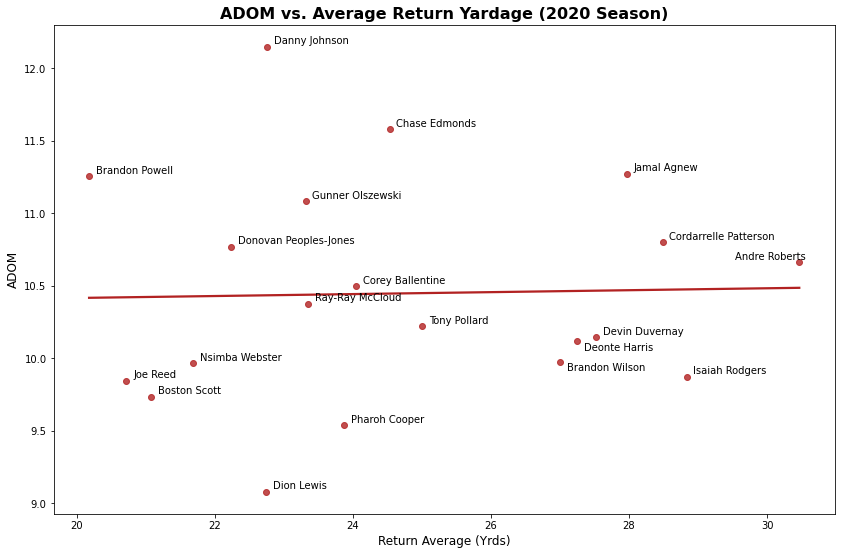

In [270]:
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text
%matplotlib inline

def scatter_text(x, y, text_column, data, title="", xlabel="", ylabel="", color="firebrick"):
    # Create the scatter plot
    p1 = sns.regplot(x, y, data=data, ci=None, color=color)
    # Add text besides each point
    texts = []
    for line in range(0,data.shape[0]):
         txt = p1.text(data[x][line]+0.1, data[y][line], 
                 data[text_column][line], horizontalalignment='left', 
                 size='medium', color="black")
         texts.append(txt)
    # Set title and axis labels
    plt.title(title, fontsize=16, fontweight="bold")
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)

    adjust_text(texts, only_move={'points':'y', 'texts':'y'})

    return p1

plt.rcParams['figure.facecolor'] = 'white'
plt.figure(figsize=(14, 9))
scatter_text('kickReturnYardage', 'adom', 'displayName',
             data = df_rank, 
             title = 'ADOM vs. Average Return Yardage (2020 Season)', 
             xlabel = 'Return Average (Yrds)',
             ylabel = 'ADOM',
             color = 'firebrick')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


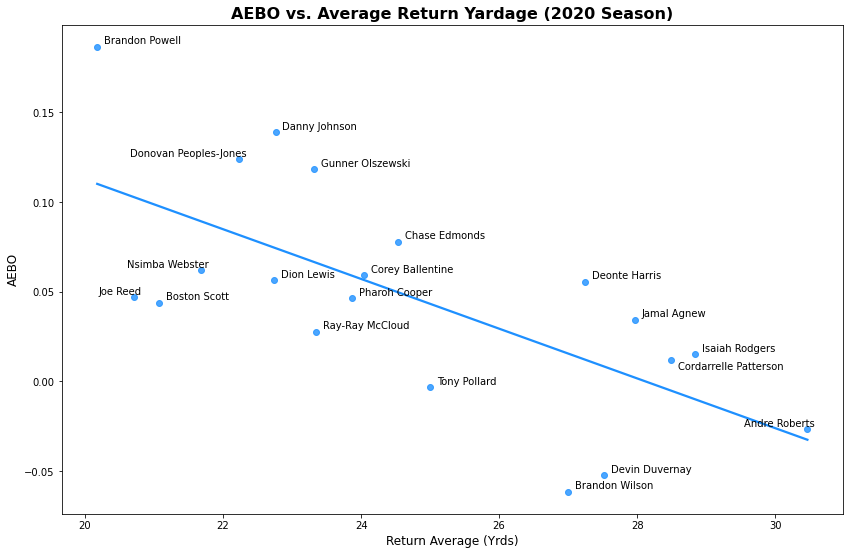

In [271]:
plt.rcParams['figure.facecolor'] = 'white'
plt.figure(figsize=(14,9))
scatter_text('kickReturnYardage', 'aebo', 'displayName',
             data = df_rank, 
             title = 'AEBO vs. Average Return Yardage (2020 Season)', 
             xlabel = 'Return Average (Yrds)',
             ylabel = 'AEBO',
             color = 'dodgerblue')
plt.show()

#### Nice ranking charts



In [199]:
df_rank = pd.read_csv("ranking.csv")
df_rank["adom_rank"] = df_rank["adom"].rank(ascending=True).apply(round)
df_rank["aebo_rank"] = df_rank["aebo"].rank(ascending=True).apply(round)
df_rank["kickReturnYardage_rank"] = df_rank["kickReturnYardage"].rank(ascending=False).apply(round)
df_rank.head()

,returnerId,kickReturnYardage,numReturns,nflId,displayName,adom,nframe,aebo,adom_rank,aebo_rank,kickReturnYardage_rank
0,35527,30.466667,30,35527,Andre Roberts,10.661511,167,-0.026785,13,3,1
1,52619,28.833333,24,52619,Isaiah Rodgers,9.873116,143,0.015233,5,6,2
2,39975,28.485714,35,39975,Cordarrelle Patterson,10.800269,198,0.011828,15,5,3
3,44978,27.964286,28,44978,Jamal Agnew,11.273803,146,0.034418,18,8,4
4,52500,27.523810,21,52500,Devin Duvernay,10.143870,105,-0.052346,9,2,5


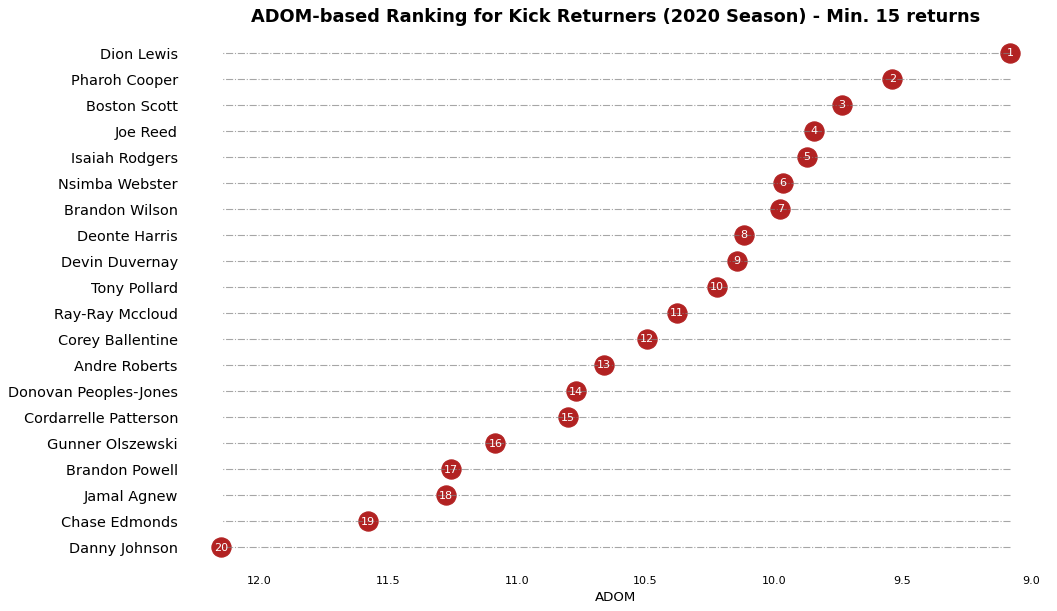

In [272]:
def rank_chart1(df, stat, hl_list: list, color='firebrick'):
    # Prepare Data
    df = df_rank.copy()
    df.sort_values(stat, inplace=True, ascending=False)
    df.reset_index(inplace=True)

    # Draw plot
    # , gridspec_kw={'width_ratios': [2, 1]}
    fig, ax = plt.subplots(figsize=(14,9), dpi=80)

    # Ax1
    ax.hlines(y=df.index, xmin=min(df[stat]), xmax=max(df[stat]), color='gray', alpha=0.7, linewidth=1, linestyles='dashdot')
    ax.scatter(y=df.index, x=df[stat], s=300, color=color, alpha=1)
    for x, y, tex in zip(df[stat], df.index, df[stat+"_rank"]):
      t = ax.text(x, y, round(tex, 1), horizontalalignment='center', 
                  verticalalignment='center', fontdict={'color':'white'})
    # Title, Label, Ticks and Ylim
    ax.set_yticks(df.index)
    ax.set_yticklabels(df.displayName.str.title(), fontdict={'horizontalalignment': 'right'})
    ax.tick_params(axis='both', which='both', length=0)  # rid of little line ticks
    # spine (box around)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # y-axis labels
    for y in ax.get_yticklabels():
      y.set_size(13)
      if y._text in hl_list:
        y.set_fontweight('bold')
    # invert, since lower ADOM means better
    ax.invert_xaxis()    

    return ax

highlights = []
chart = rank_chart1(df_rank, 'adom', highlights)
chart.set_title('ADOM-based Ranking for Kick Returners (2020 Season) - Min. 15 returns', fontsize=16, fontweight="bold")
chart.set_xlabel('ADOM', fontsize=12)
plt.rcParams['figure.facecolor'] = 'white'
plt.show()

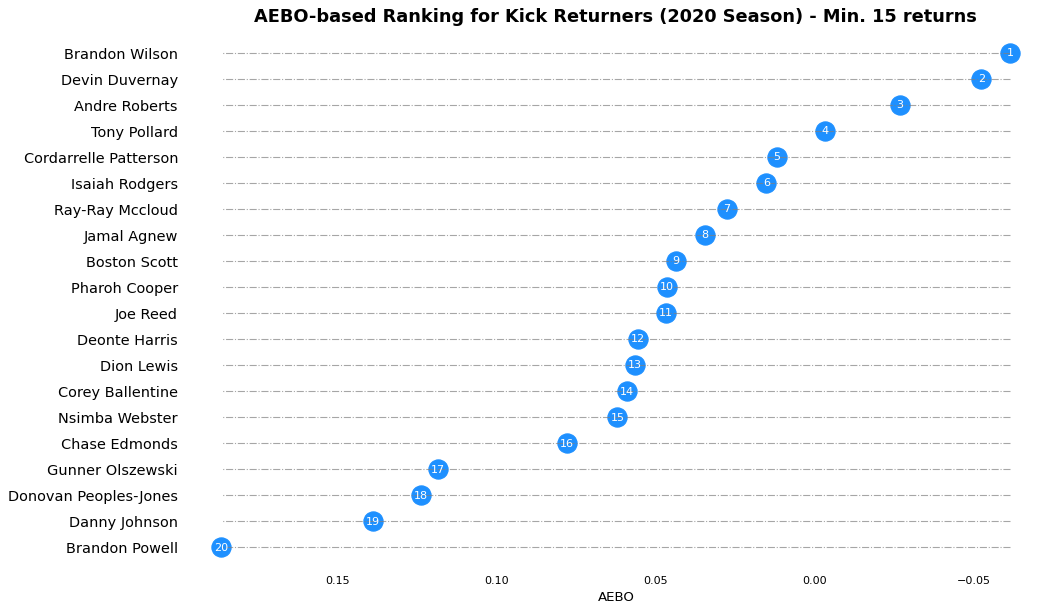

In [273]:
highlights = []
chart = rank_chart1(df_rank, 'aebo', highlights,"dodgerblue")
chart.set_title('AEBO-based Ranking for Kick Returners (2020 Season) - Min. 15 returns', fontsize=16, fontweight="bold")
chart.set_xlabel('AEBO', fontsize=12)
plt.rcParams['figure.facecolor'] = 'white'
plt.show()

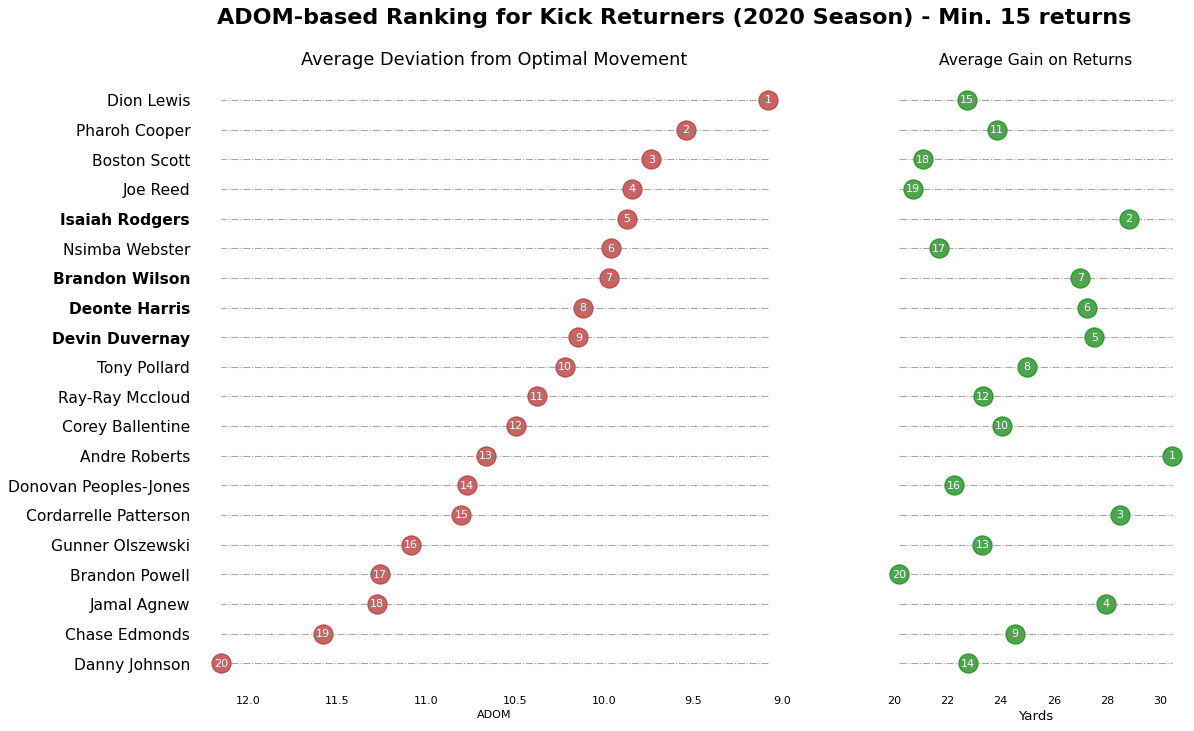

In [207]:
def rank_chart2(df, stat, hl_list: list):
    # Prepare Data
    df = df_rank.copy()
    df.sort_values(stat, inplace=True, ascending=False)
    df.reset_index(inplace=True)

    # Draw plot
    # , gridspec_kw={'width_ratios': [2, 1]}
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,10), dpi=80, sharey=True, gridspec_kw={'width_ratios': [2, 1]})

    # Ax1
    ax1.hlines(y=df.index, xmin=min(df[stat]), xmax=max(df[stat]), color='gray', alpha=0.7, linewidth=1, linestyles='dashdot')
    ax1.scatter(y=df.index, x=df[stat], s=300, color='firebrick', alpha=0.7)
    for x, y, tex in zip(df[stat], df.index, df[stat+"_rank"]):
      t = ax1.text(x, y, round(tex, 1), horizontalalignment='center', 
                  verticalalignment='center', fontdict={'color':'white'})
    # Title, Label, Ticks and Ylim
    ax1.set_yticks(df.index)
    ax1.set_yticklabels(df.displayName.str.title(), fontdict={'horizontalalignment': 'right'})
    ax1.tick_params(axis='both', which='both', length=0)  # rid of little line ticks
    # spine (box around)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    # y-axis labels
    for y in ax1.get_yticklabels():
      y.set_size(14)
      if y._text in hl_list:
        y.set_fontweight('bold')
    # invert, since lower ADOM means better
    ax1.invert_xaxis()    

    # ax2
    ax2.hlines(y=df.index, xmin=min(df['kickReturnYardage']), xmax=max(df['kickReturnYardage']), color='gray', alpha=0.7, linewidth=1, linestyles='dashdot')
    ax2.scatter(y=df.index, x=df['kickReturnYardage'], s=300, color='green', alpha=0.7)
    for x, y, tex in zip(df['kickReturnYardage'], df.index, df["kickReturnYardage_rank"]):
      t = ax2.text(x, y, round(tex, 1), horizontalalignment='center', 
                  verticalalignment='center', fontdict={'color':'white'})
    ax2.set_title('Average Gain on Returns', fontsize=14)
    ax2.set_xlabel("Yards", fontsize=12)
    ax2.tick_params(axis='both', which='both', length=0)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_visible(False)

    return fig, ax1, ax2

highlights = ['Isaiah Rodgers', 'Brandon Wilson', 'Deonte Harris', 'Devin Duvernay']

main, chart1, chart2 = rank_chart2(df_rank, 'adom', highlights)
main.suptitle('ADOM-based Ranking for Kick Returners (2020 Season) - Min. 15 returns', fontsize=20, fontweight='bold')
main.subplots_adjust(top=0.9)
chart1.set_title('Average Deviation from Optimal Movement', fontsize=16)
chart1.set_xlabel('ADOM', fontsize=12)
plt.rcParams['figure.facecolor'] = 'white'
plt.show()

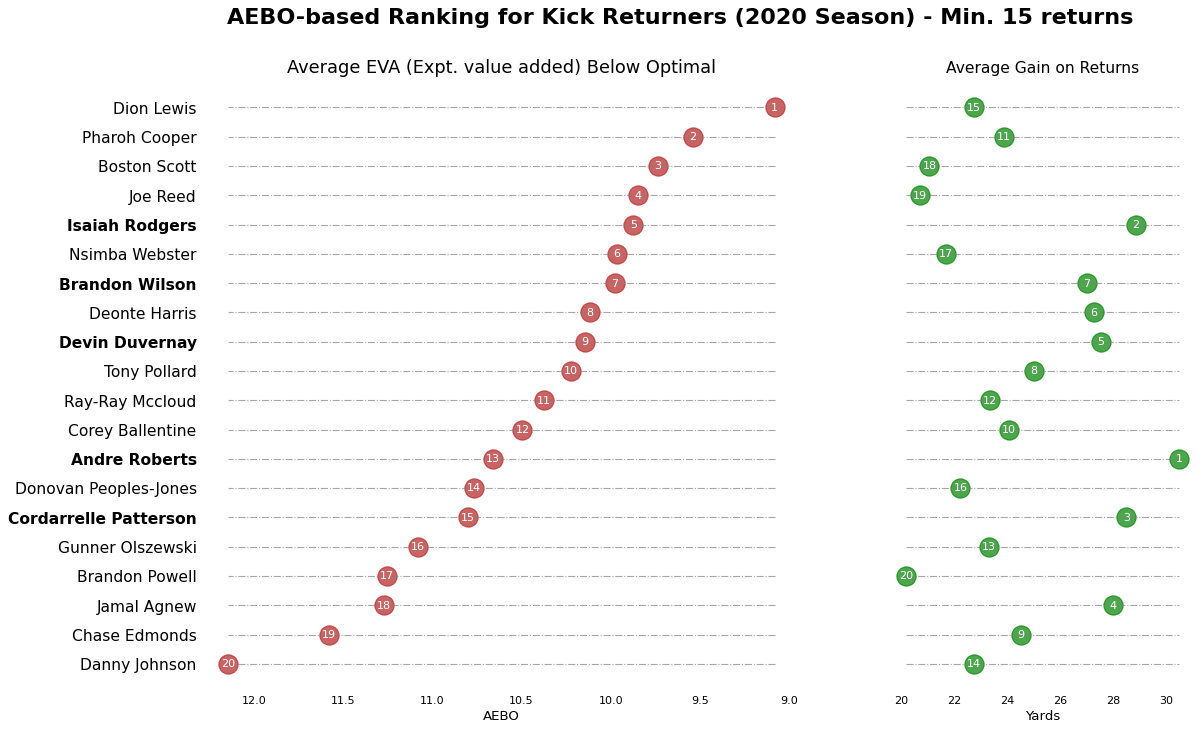

In [208]:
highlights = ['Brandon Wilson', 'Isaiah Rodgers', 'Devin Duvernay', 'Andre Roberts', 'Cordarrelle Patterson', 'Isaiah Rodgers']
main, chart1, chart2 = rank_chart2(df_rank, 'adom', highlights)
main.suptitle('AEBO-based Ranking for Kick Returners (2020 Season) - Min. 15 returns', fontsize=20, fontweight='bold')
main.subplots_adjust(top=0.89)
chart1.set_title('Average EVA (Expt. value added) Below Optimal', fontsize=16)
chart1.set_xlabel('AEBO', fontsize=12)
plt.rcParams['figure.facecolor'] = 'white'
plt.show()

## Simulation 2: For the first 20 frames of the kick return, simulate the kick returner's entire path, using the actual locations of all the other players. 

### _Simulation of Type 2_. 

In [274]:
import warnings
warnings.filterwarnings('ignore')

def get_all_optimal_locs_type2(kr_pf_df, max_frames = 20):
  '''kr_pf_df consists of all frames of one kick return, in pre-feature format.
     return a list of (x,y) coordinates consisting of the optimal next locations
     of the kick returner for each frame, keeping all the defenders and blockers
     positions as observed, but letting the kick returner's position evolve as a
     markov chain.'''
  max_frames = min([max_frames, kr_pf_df.shape[0]])
  alg_locs = []
  curr_pf = kr_pf_df.iloc[[0]].reset_index(drop=True) # initial frame
  x0 = round(curr_pf['x_kr'].iloc[0] ,2)
  y0 = round(curr_pf['y_kr'].iloc[0] ,2)
  alg_locs.append((x0,y0)) # add the observed starting point (x0,y0).

  for i in range(max_frames - 1): 
    print(i, end= "\n" if i % max_frames == 0 else " ")
    curr_pf = kr_pf_df.iloc[[i]].reset_index(drop=True) # current frame
    x0_sim, y0_sim = alg_locs[-1]
    curr_pf['x_kr'].iloc[0] = x0_sim
    curr_pf['y_kr'].iloc[0] = y0_sim
    x1,y1 = get_optimal_next_loc(curr_pf, p='kr')
    alg_locs.append((x1,y1))

  return(alg_locs)

Perform simulation of type 2 on an example kick return.

In [ ]:
unique_KR_firstFrame = dat_test.groupby(by=['gameId','playId']).first().reset_index()[['gameId','playId','frameId']].rename(columns={"frameId": "firstFrame"})
unique_KR_lastFrame = dat_test.groupby(by=['gameId','playId']).last().reset_index()[['gameId','playId','frameId']].rename(columns={"frameId": "lastFrame"})
unique_KR = unique_KR_firstFrame.merge(unique_KR_lastFrame, how="left")
unique_KR['numFrames'] = unique_KR['lastFrame'] - unique_KR['firstFrame']
unique_KR = unique_KR.sort_values(by='numFrames',ascending=False)
unique_KR
unique_KR.query('numFrames >= 50 and numFrames <= 52')

In [277]:
pre_feature_df = pd.read_csv('drive/My Drive/kaggle/BDB22/pre_feature_df.csv')
pf_df_ex1 = pre_feature_df.query('gameId == 2020122008 & playId == 3856')
pf_df_ex2 = pre_feature_df.query('gameId == 2019122905 & playId == 3587')
pf_df_ex3 = pre_feature_df.query('gameId == 2019122913 & playId == 4370')
pf_df_ex4 = pre_feature_df.query('gameId == 2019112411 & playId == 46')
pf_df_ex5 = pre_feature_df.query('gameId == 2018102102 & playId == 955')
pf_df_ex6 = pre_feature_df.query('gameId == 2019102712 & playId == 896')
del(pre_feature_df);

In [278]:
pre_feature_df_by_tag = pd.read_csv('drive/My Drive/kaggle/BDB22/pre_feature_df_by_tag.csv')
pf_df_by_tag_ex1 = pre_feature_df_by_tag.query('gameId == 2020122008 & playId == 3856')
pf_df_by_tag_ex2 = pre_feature_df_by_tag.query('gameId == 2019122905 & playId == 3587')
pf_df_by_tag_ex3 = pre_feature_df_by_tag.query('gameId == 2019122913 & playId == 4370')
pf_df_by_tag_ex4 = pre_feature_df_by_tag.query('gameId == 2019112411 & playId == 46')
pf_df_by_tag_ex5 = pre_feature_df_by_tag.query('gameId == 2018102102 & playId == 955')
pf_df_by_tag_ex6 = pre_feature_df_by_tag.query('gameId == 2019102712 & playId == 896')
del(pre_feature_df_by_tag); 

In [ ]:
# computed and observed KR locations for this kick return
alg_locs_ex1_type2 = get_all_optimal_locs_type2(pf_df_ex1)
alg_locs_ex2_type2 = get_all_optimal_locs_type2(pf_df_ex2)
alg_locs_ex3_type2 = get_all_optimal_locs_type2(pf_df_ex3)
alg_locs_ex4_type2 = get_all_optimal_locs_type2(pf_df_ex4)
alg_locs_ex5_type2 = get_all_optimal_locs_type2(pf_df_ex5)
alg_locs_ex6_type2 = get_all_optimal_locs_type2(pf_df_ex6)

# save
np.savetxt('drive/My Drive/kaggle/BDB22/alg_locs_ex1_type2.txt', alg_locs_ex1_type2)
np.savetxt('drive/My Drive/kaggle/BDB22/alg_locs_ex2_type2.txt', alg_locs_ex2_type2)
np.savetxt('drive/My Drive/kaggle/BDB22/alg_locs_ex3_type2.txt', alg_locs_ex3_type2)
np.savetxt('drive/My Drive/kaggle/BDB22/alg_locs_ex4_type2.txt', alg_locs_ex4_type2)
np.savetxt('drive/My Drive/kaggle/BDB22/alg_locs_ex5_type2.txt', alg_locs_ex5_type2)
np.savetxt('drive/My Drive/kaggle/BDB22/alg_locs_ex6_type2.txt', alg_locs_ex6_type2)

### __Animation__ of our simulation of type 2 on our example kick returns.

In [ ]:
### load KR points
alg_locs_ex1_type2 = np.loadtxt('drive/My Drive/kaggle/BDB22/alg_locs_ex1_type2.txt')
alg_locs_ex2_type2 = np.loadtxt('drive/My Drive/kaggle/BDB22/alg_locs_ex2_type2.txt')
alg_locs_ex3_type2 = np.loadtxt('drive/My Drive/kaggle/BDB22/alg_locs_ex3_type2.txt')
alg_locs_ex4_type2 = np.loadtxt('drive/My Drive/kaggle/BDB22/alg_locs_ex4_type2.txt')
alg_locs_ex5_type2 = np.loadtxt('drive/My Drive/kaggle/BDB22/alg_locs_ex5_type2.txt')
alg_locs_ex6_type2 = np.loadtxt('drive/My Drive/kaggle/BDB22/alg_locs_ex6_type2.txt')


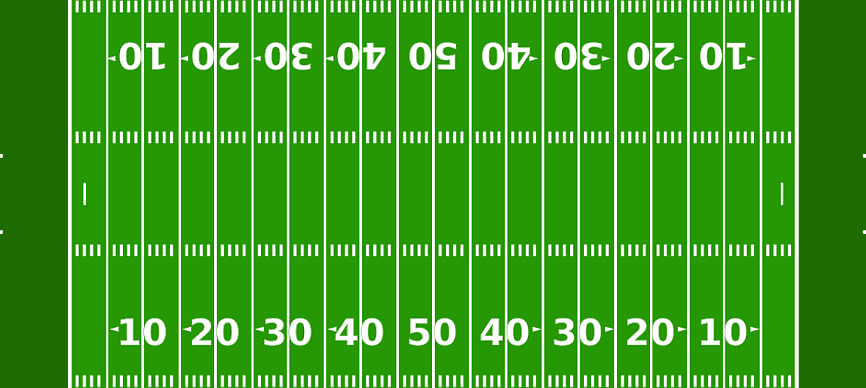

In [ ]:
make_animation(pf_df_by_tag_ex1.iloc[:len(alg_locs_ex1_type2)], alg_locs_ex1_type2)

In [ ]:
make_animation(pf_df_by_tag_ex2.iloc[:len(alg_locs_ex2_type2)], alg_locs_ex2_type2)

In [ ]:
make_animation(pf_df_by_tag_ex3.iloc[:len(alg_locs_ex3_type2)], alg_locs_ex3_type2)

In [ ]:
make_animation(pf_df_by_tag_ex4.iloc[:len(alg_locs_ex4_type2)], alg_locs_ex4_type2)

In [ ]:
make_animation(pf_df_by_tag_ex5.iloc[:len(alg_locs_ex5_type2)], alg_locs_ex5_type2)

In [ ]:
make_animation(pf_df_by_tag_ex6.iloc[:len(alg_locs_ex6_type2)], alg_locs_ex6_type2)

Notice how our simiulated kick returner immediately veers to the sideline.

__Story__: players should go to the sidelines instead of up the middle. Players are going for a TD, which is high variance but a low median.